In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.datasets import daocensus_text
import src.utils.notebooks as nbutils

sns.set_theme()
plt.rcParams['figure.dpi'] = 600

In [2]:
# 'ORG_NAME', 'ORG_PLATFORM', 'SPLITS_FREQ', 'SPLITS_NORMALIZE', 'LAST_SPLITS', 'USE_ORG_NAMES'

ORG_NAME = 'Aave - Aavegotchi'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES = True

# Not used
SPLITS_FREQ = ...
SPLITS_NORMALIZE = ...
LAST_SPLITS = ...

In [3]:
# Parameters
ORG_NAME = "Balancer"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 12s:00"


In [4]:
dfv, dfp = daocensus_text.get('./data/daos-census-text', ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 111987 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111987 entries, 0 to 111986
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       111987 non-null  object        
 1   name           111987 non-null  object        
 2   id             111987 non-null  object        
 3   proposal       111987 non-null  category      
 4   deployment     111987 non-null  object        
 5   platform_vote  111987 non-null  object        
 6   voter          111987 non-null  category      
 7   date           111987 non-null  datetime64[ns]
 8   choice         111987 non-null  object        
 9   weight         111987 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 8.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 509 entries, 634da5d5-f4f1-5b3d-b000-dcceecfe6075 to d40d5b48-1a3d-53c6-

# Exploración de datos de Decentraland

In [5]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

Balancer tiene 111987 votos de 9107 voters en 509 propuestas


In [6]:
dfd = dfp[['platform', 'name', 'platform_deployment']].drop_duplicates()
dfd

platform      name platform_deployment
id                                                                          
634da5d5-f4f1-5b3d-b000-dcceecfe6075  snapshot  Balancer        balancer.eth

## Histograma de votos por usuario

9107
214
count    9107.000000
mean       12.296805
std        29.355697
min         1.000000
50%         4.000000
90%        22.000000
95%        49.000000
99%       170.880000
max       373.000000
dtype: float64


Cannot show ipywidgets in text

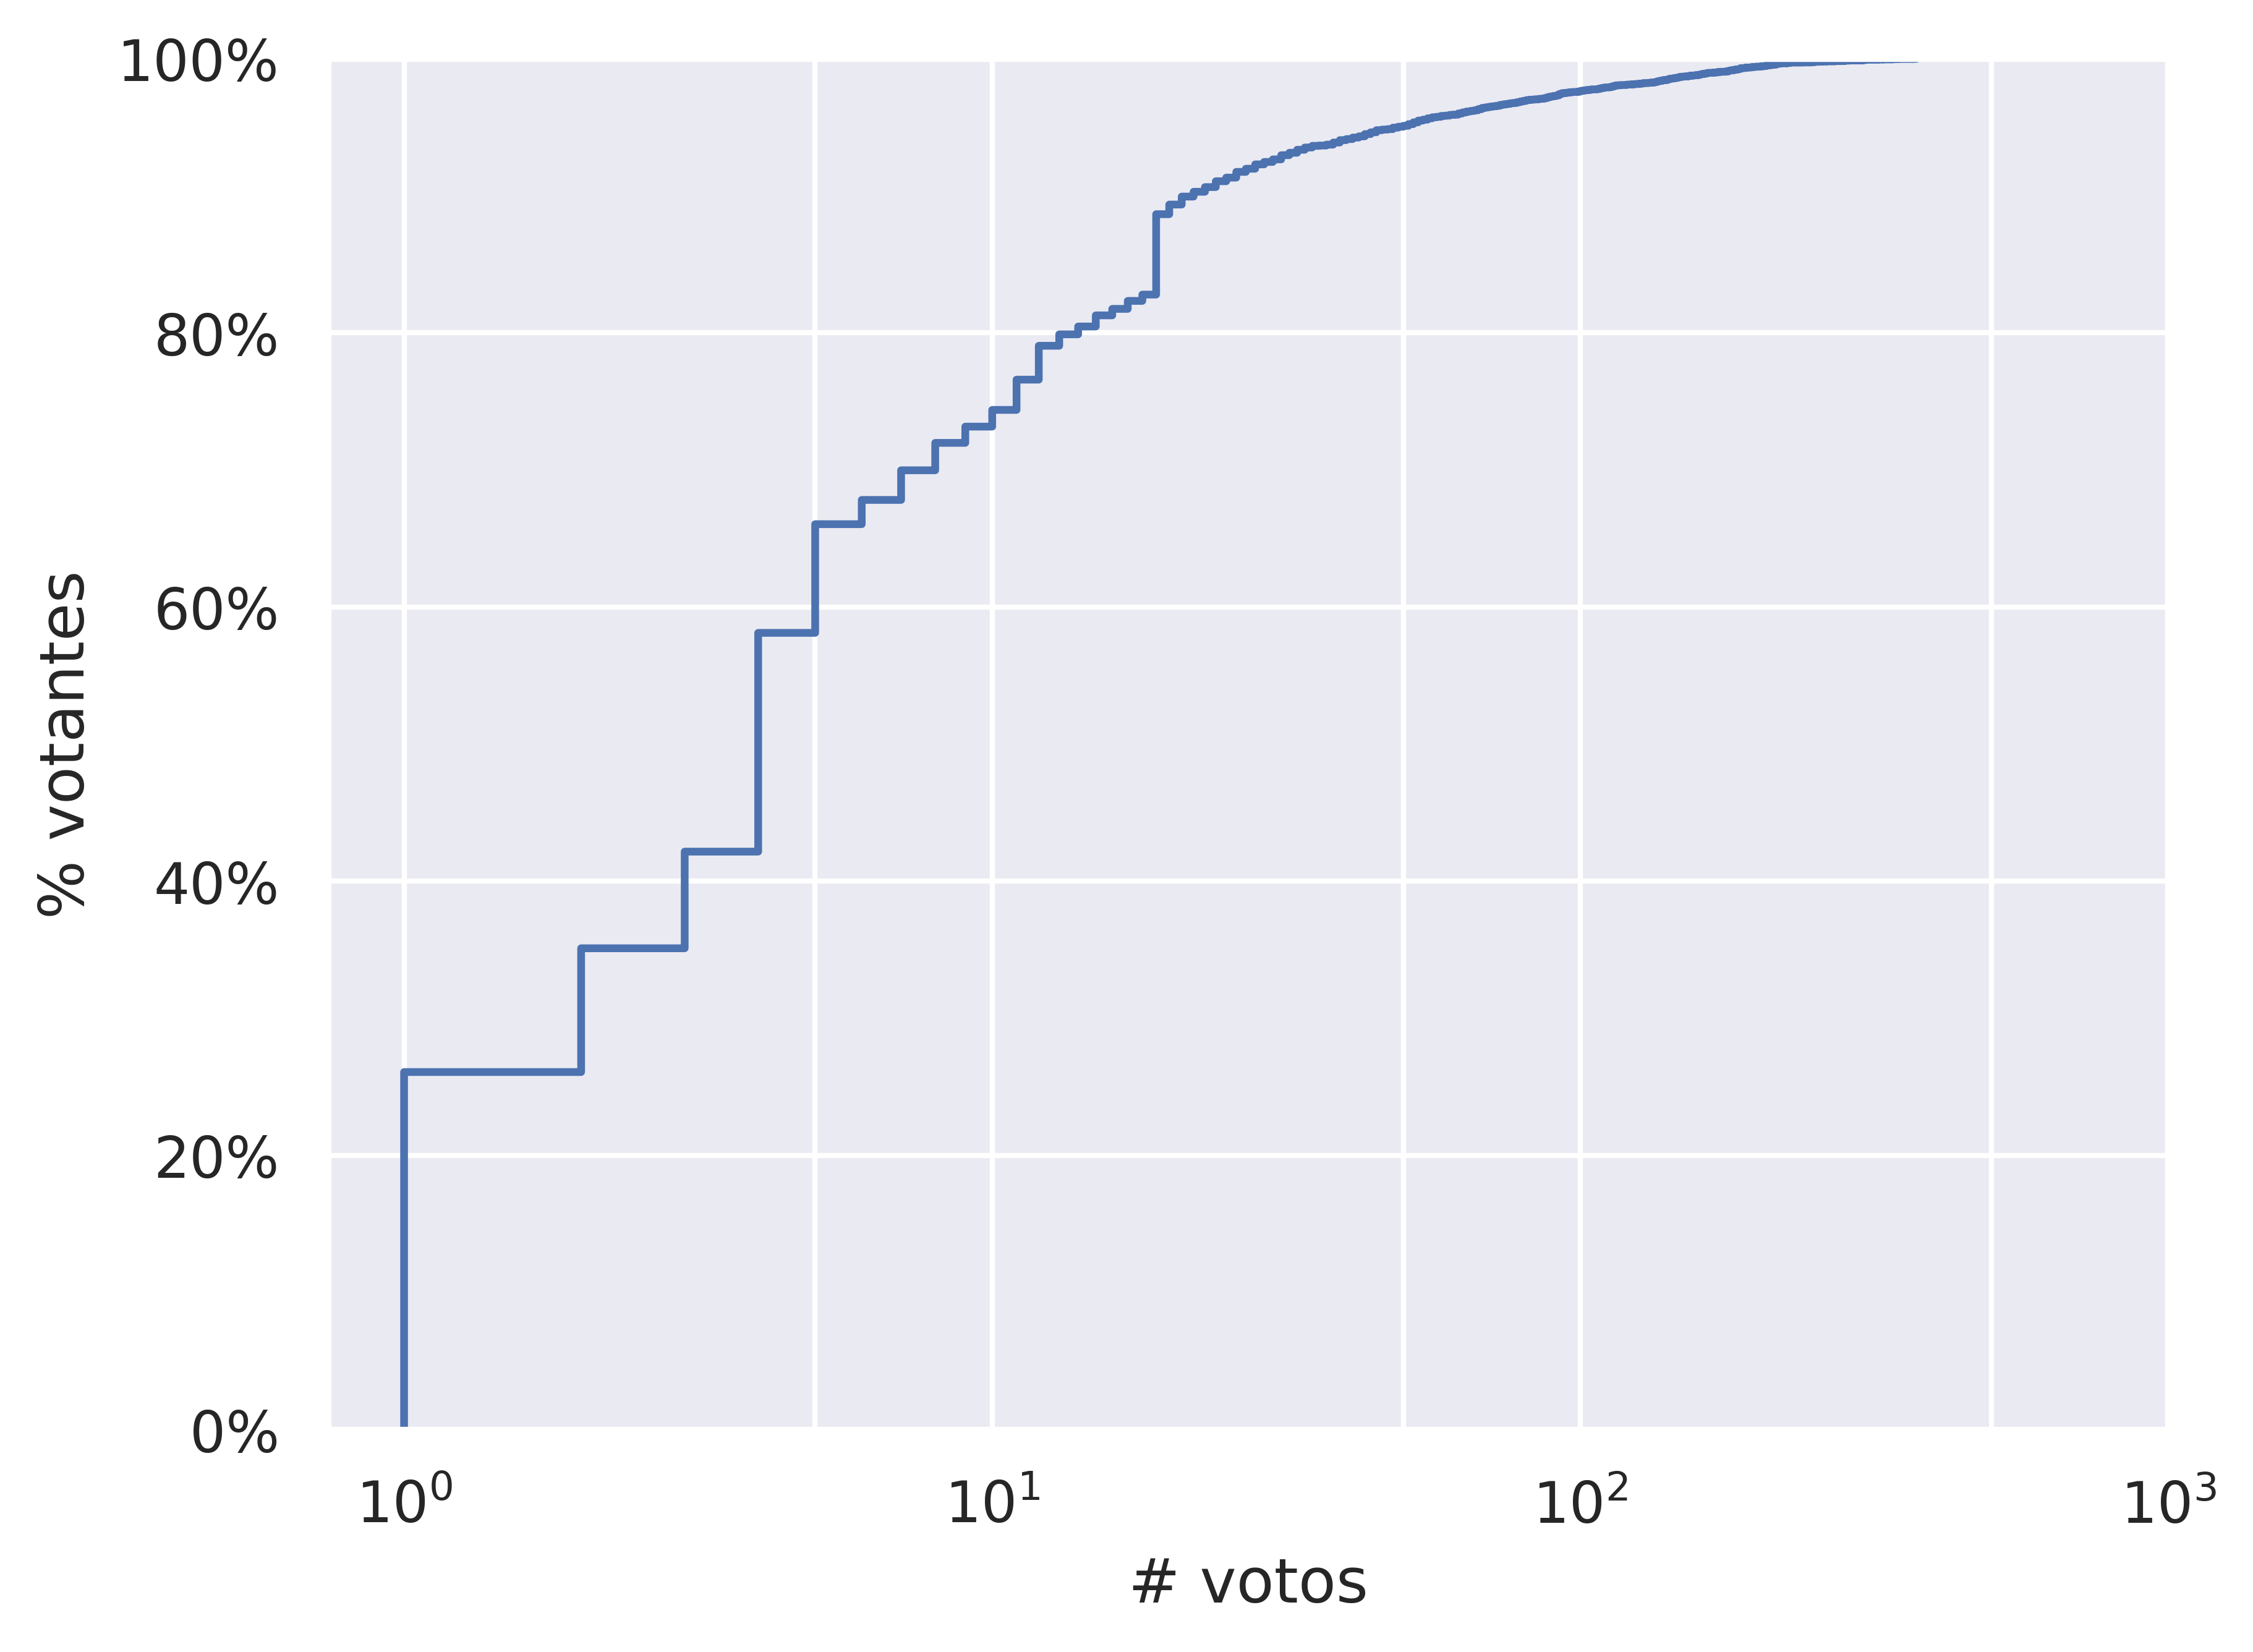

In [7]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print( len(_toplot) )
print( (_toplot > 100).sum() )
print(_toplot.describe(percentiles=[.5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votos')
plt.ylabel('% votantes')

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_voters_{ORG_NAME}.pdf')

## Histograma de votos por propuesta

count     509.000000
mean      220.062868
std       253.148621
min         8.000000
50%       146.000000
75%       255.000000
90%       341.400000
95%       720.600000
99%      1463.480000
max      2102.000000
Name: votes_count, dtype: float64
79


Cannot show ipywidgets in text

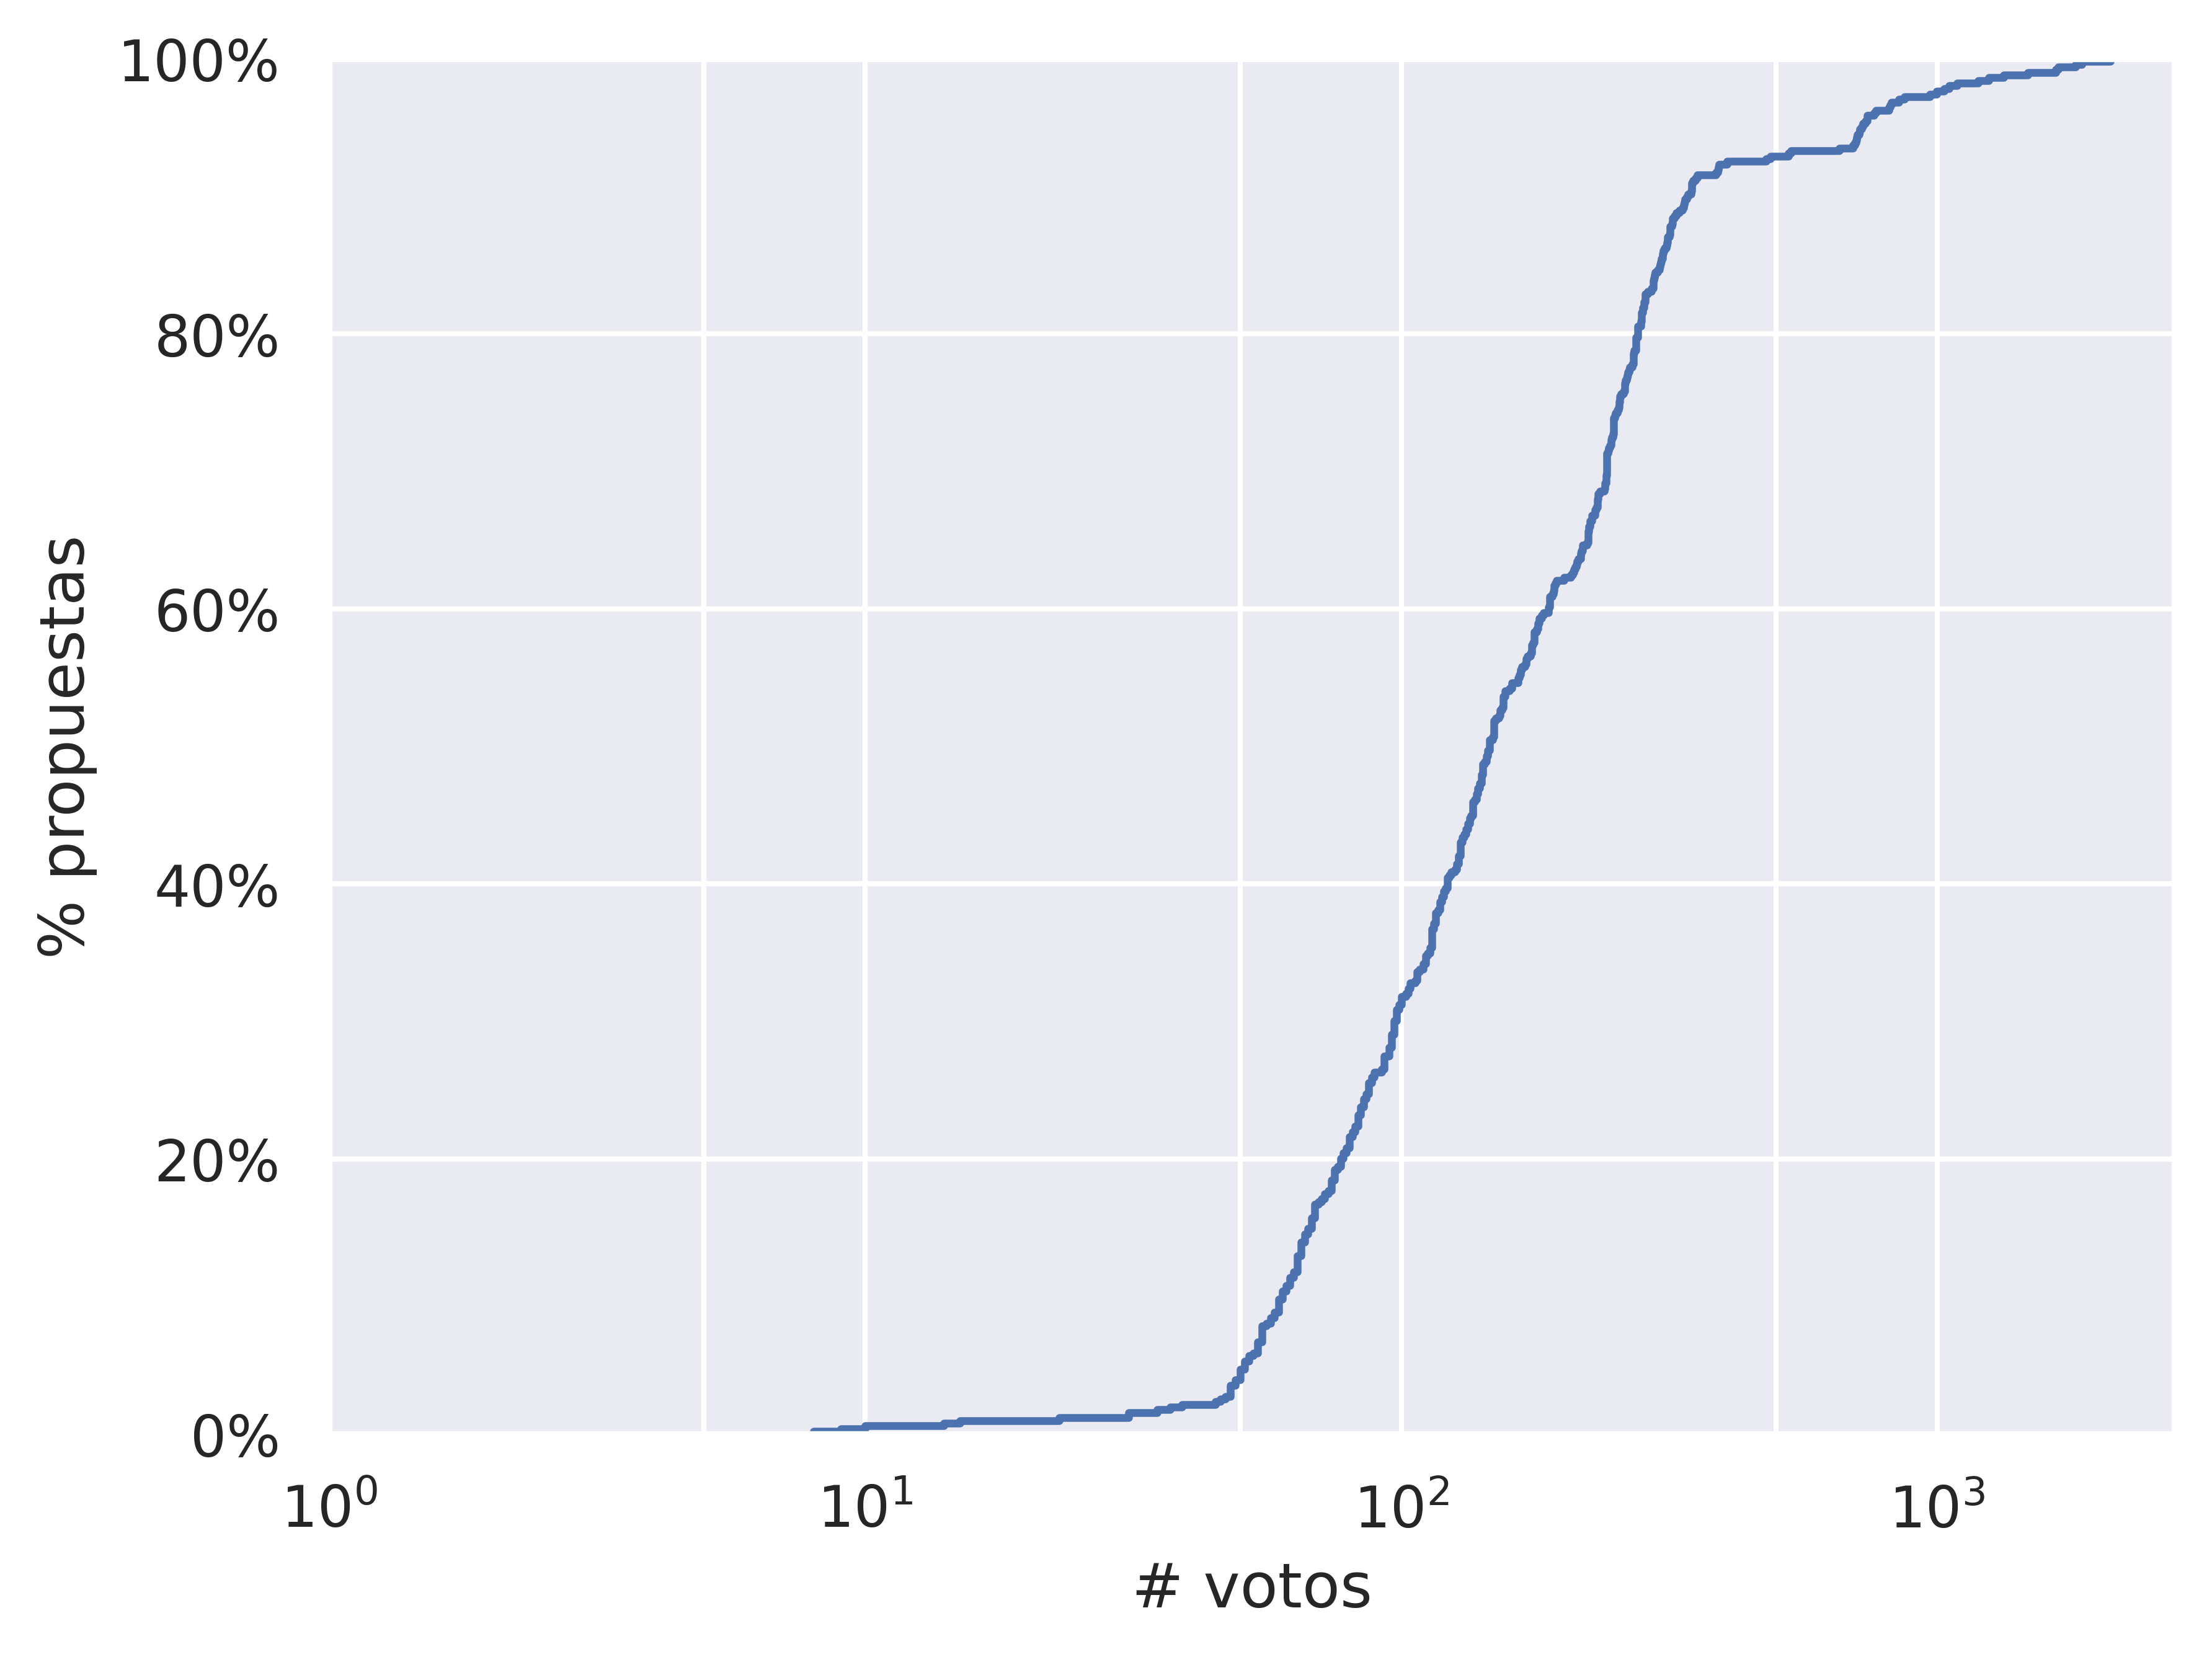

In [8]:
_toplot = dfp['votes_count']
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xlabel('# votos')
plt.ylabel('% propuestas')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_proposals_{ORG_NAME}.pdf')

count     509.000000
mean      220.013752
std       253.149698
min         8.000000
50%       146.000000
75%       255.000000
90%       341.400000
95%       720.600000
99%      1463.480000
max      2102.000000
dtype: float64
79


<Axes: ylabel='Proportion'>

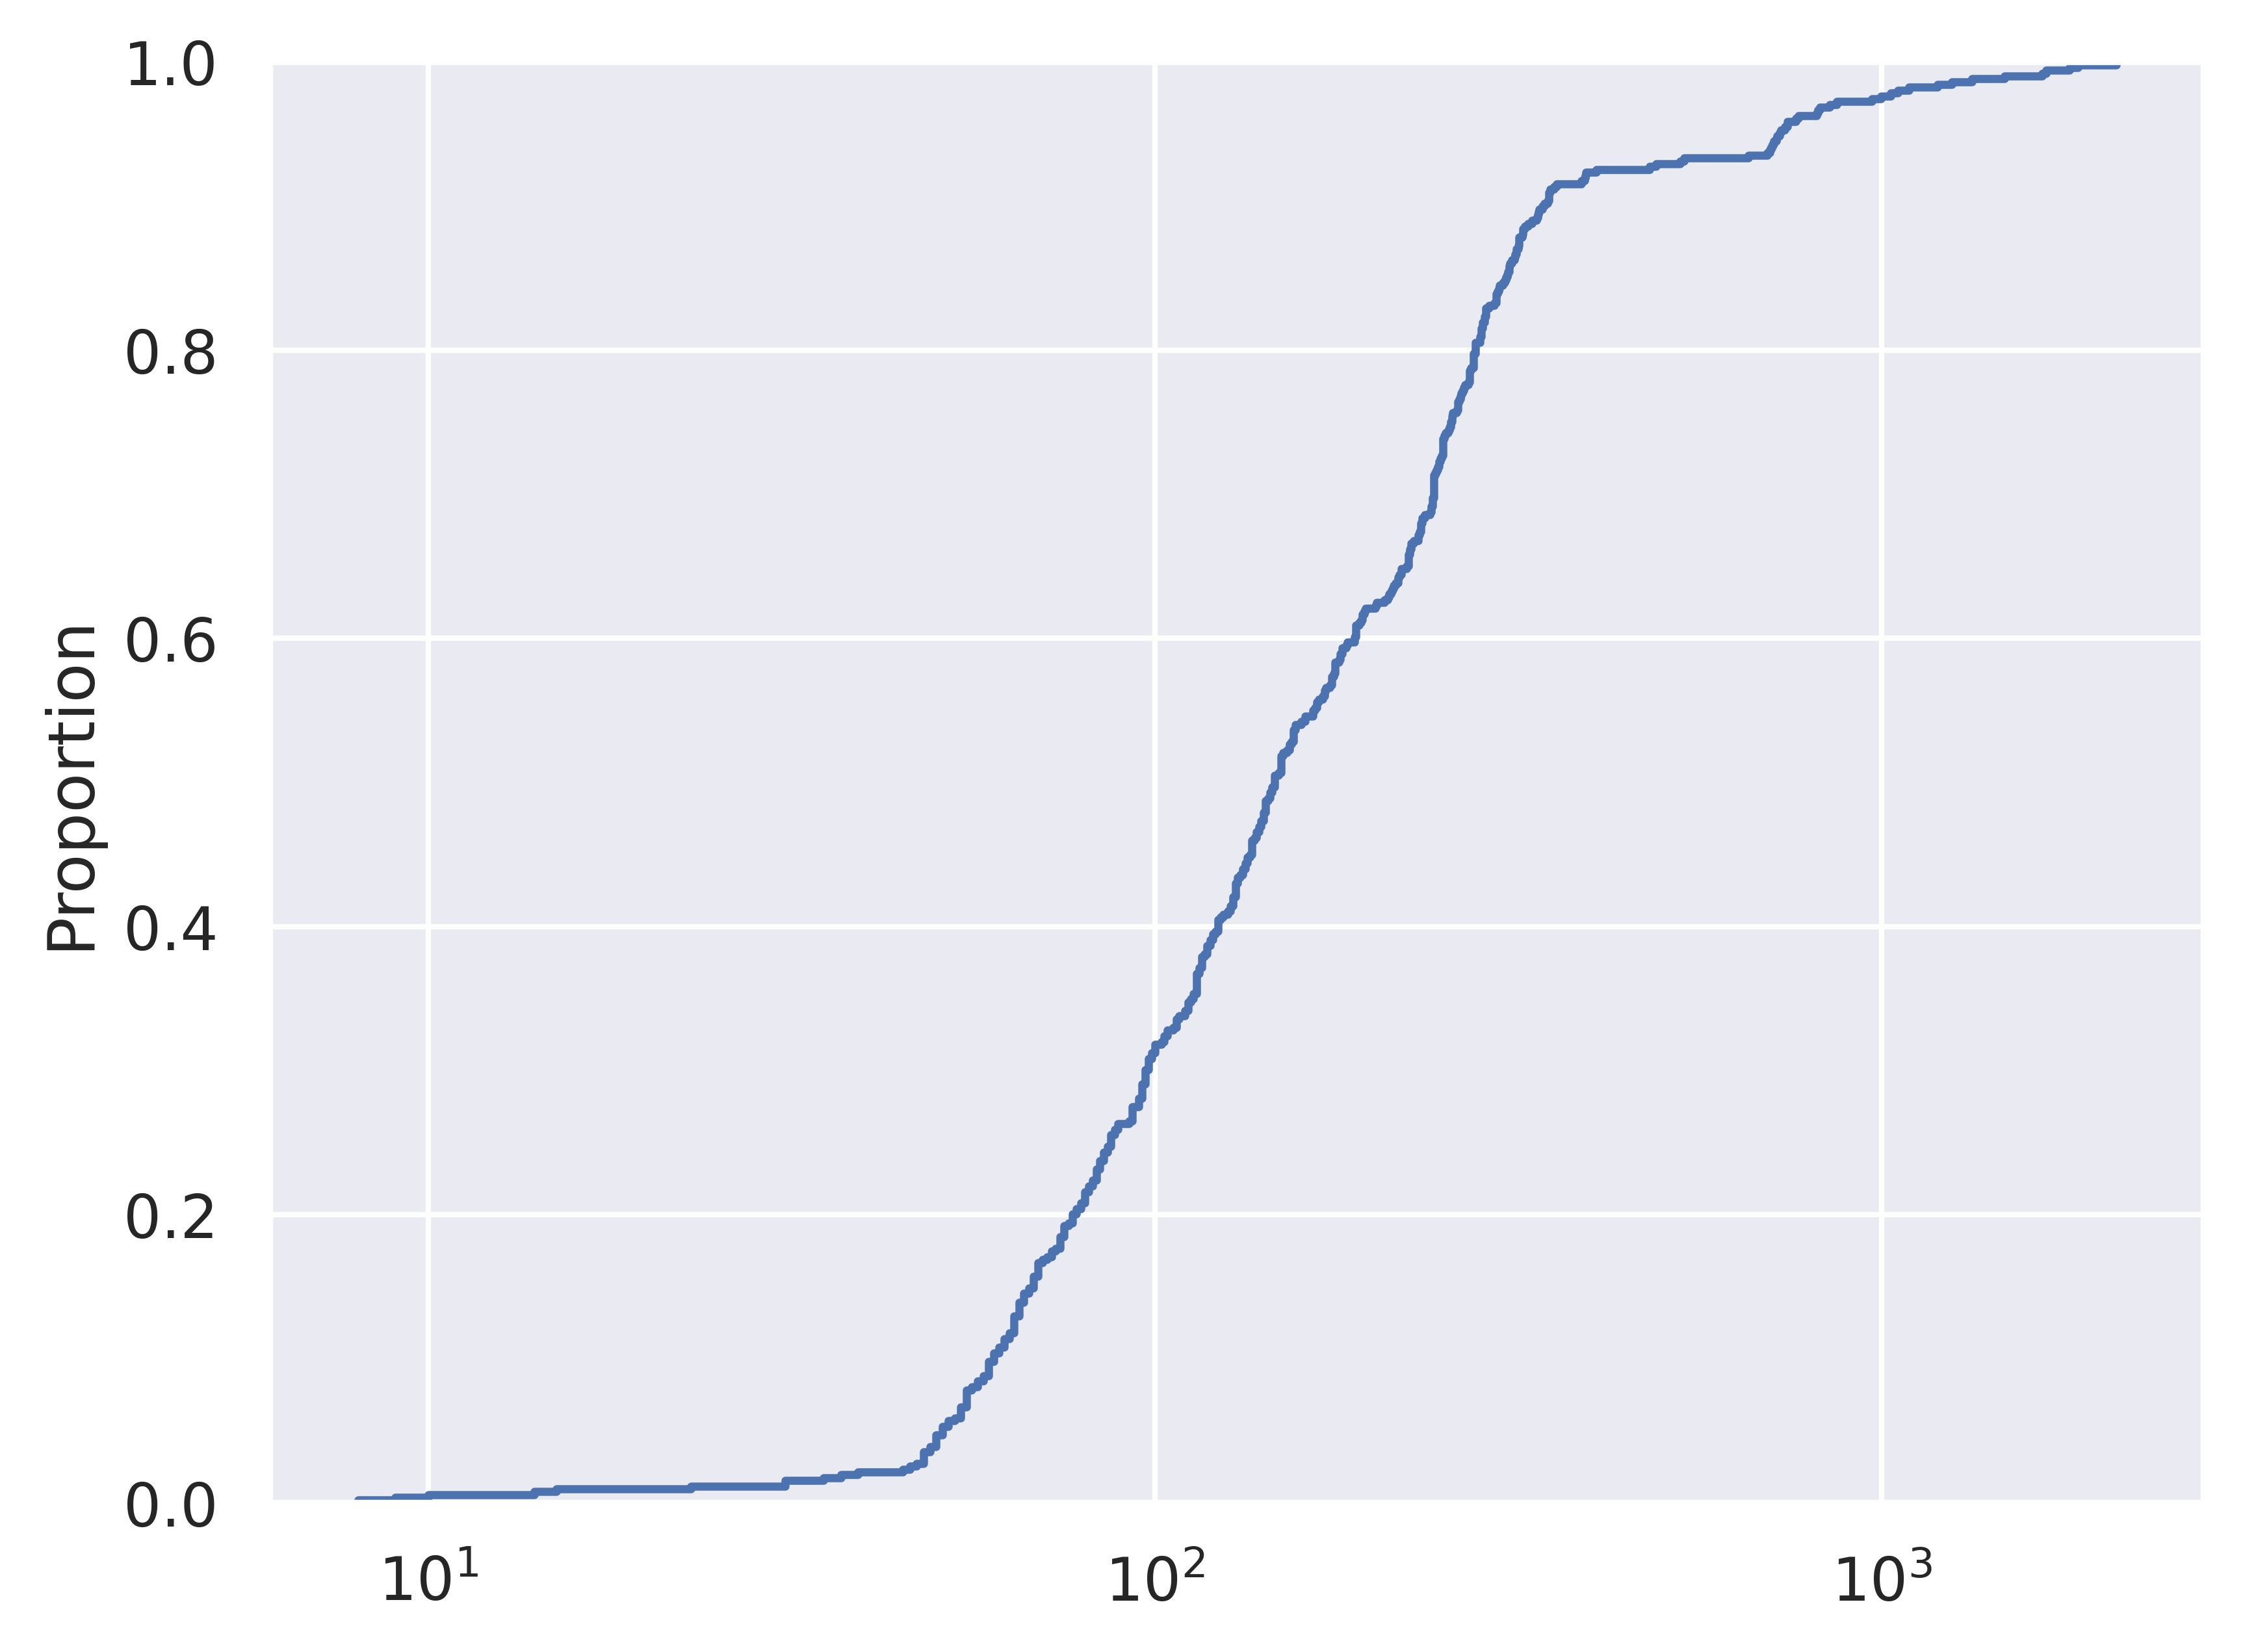

In [9]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )
sns.ecdfplot(_toplot, log_scale=True)

### Usuarios activos

In [10]:
# dfv.set_index('date').sort_index()['voter'].tolist()
# for x in dfv.set_index('date').sort_index()['voter'].items():
#     print(x)

/tmp/ipykernel_180957/3928196604.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/111987 [00:00<?, ?it/s]

2020-07-18 16:12:04 2023-07-17 17:57:23


Cannot show ipywidgets in text

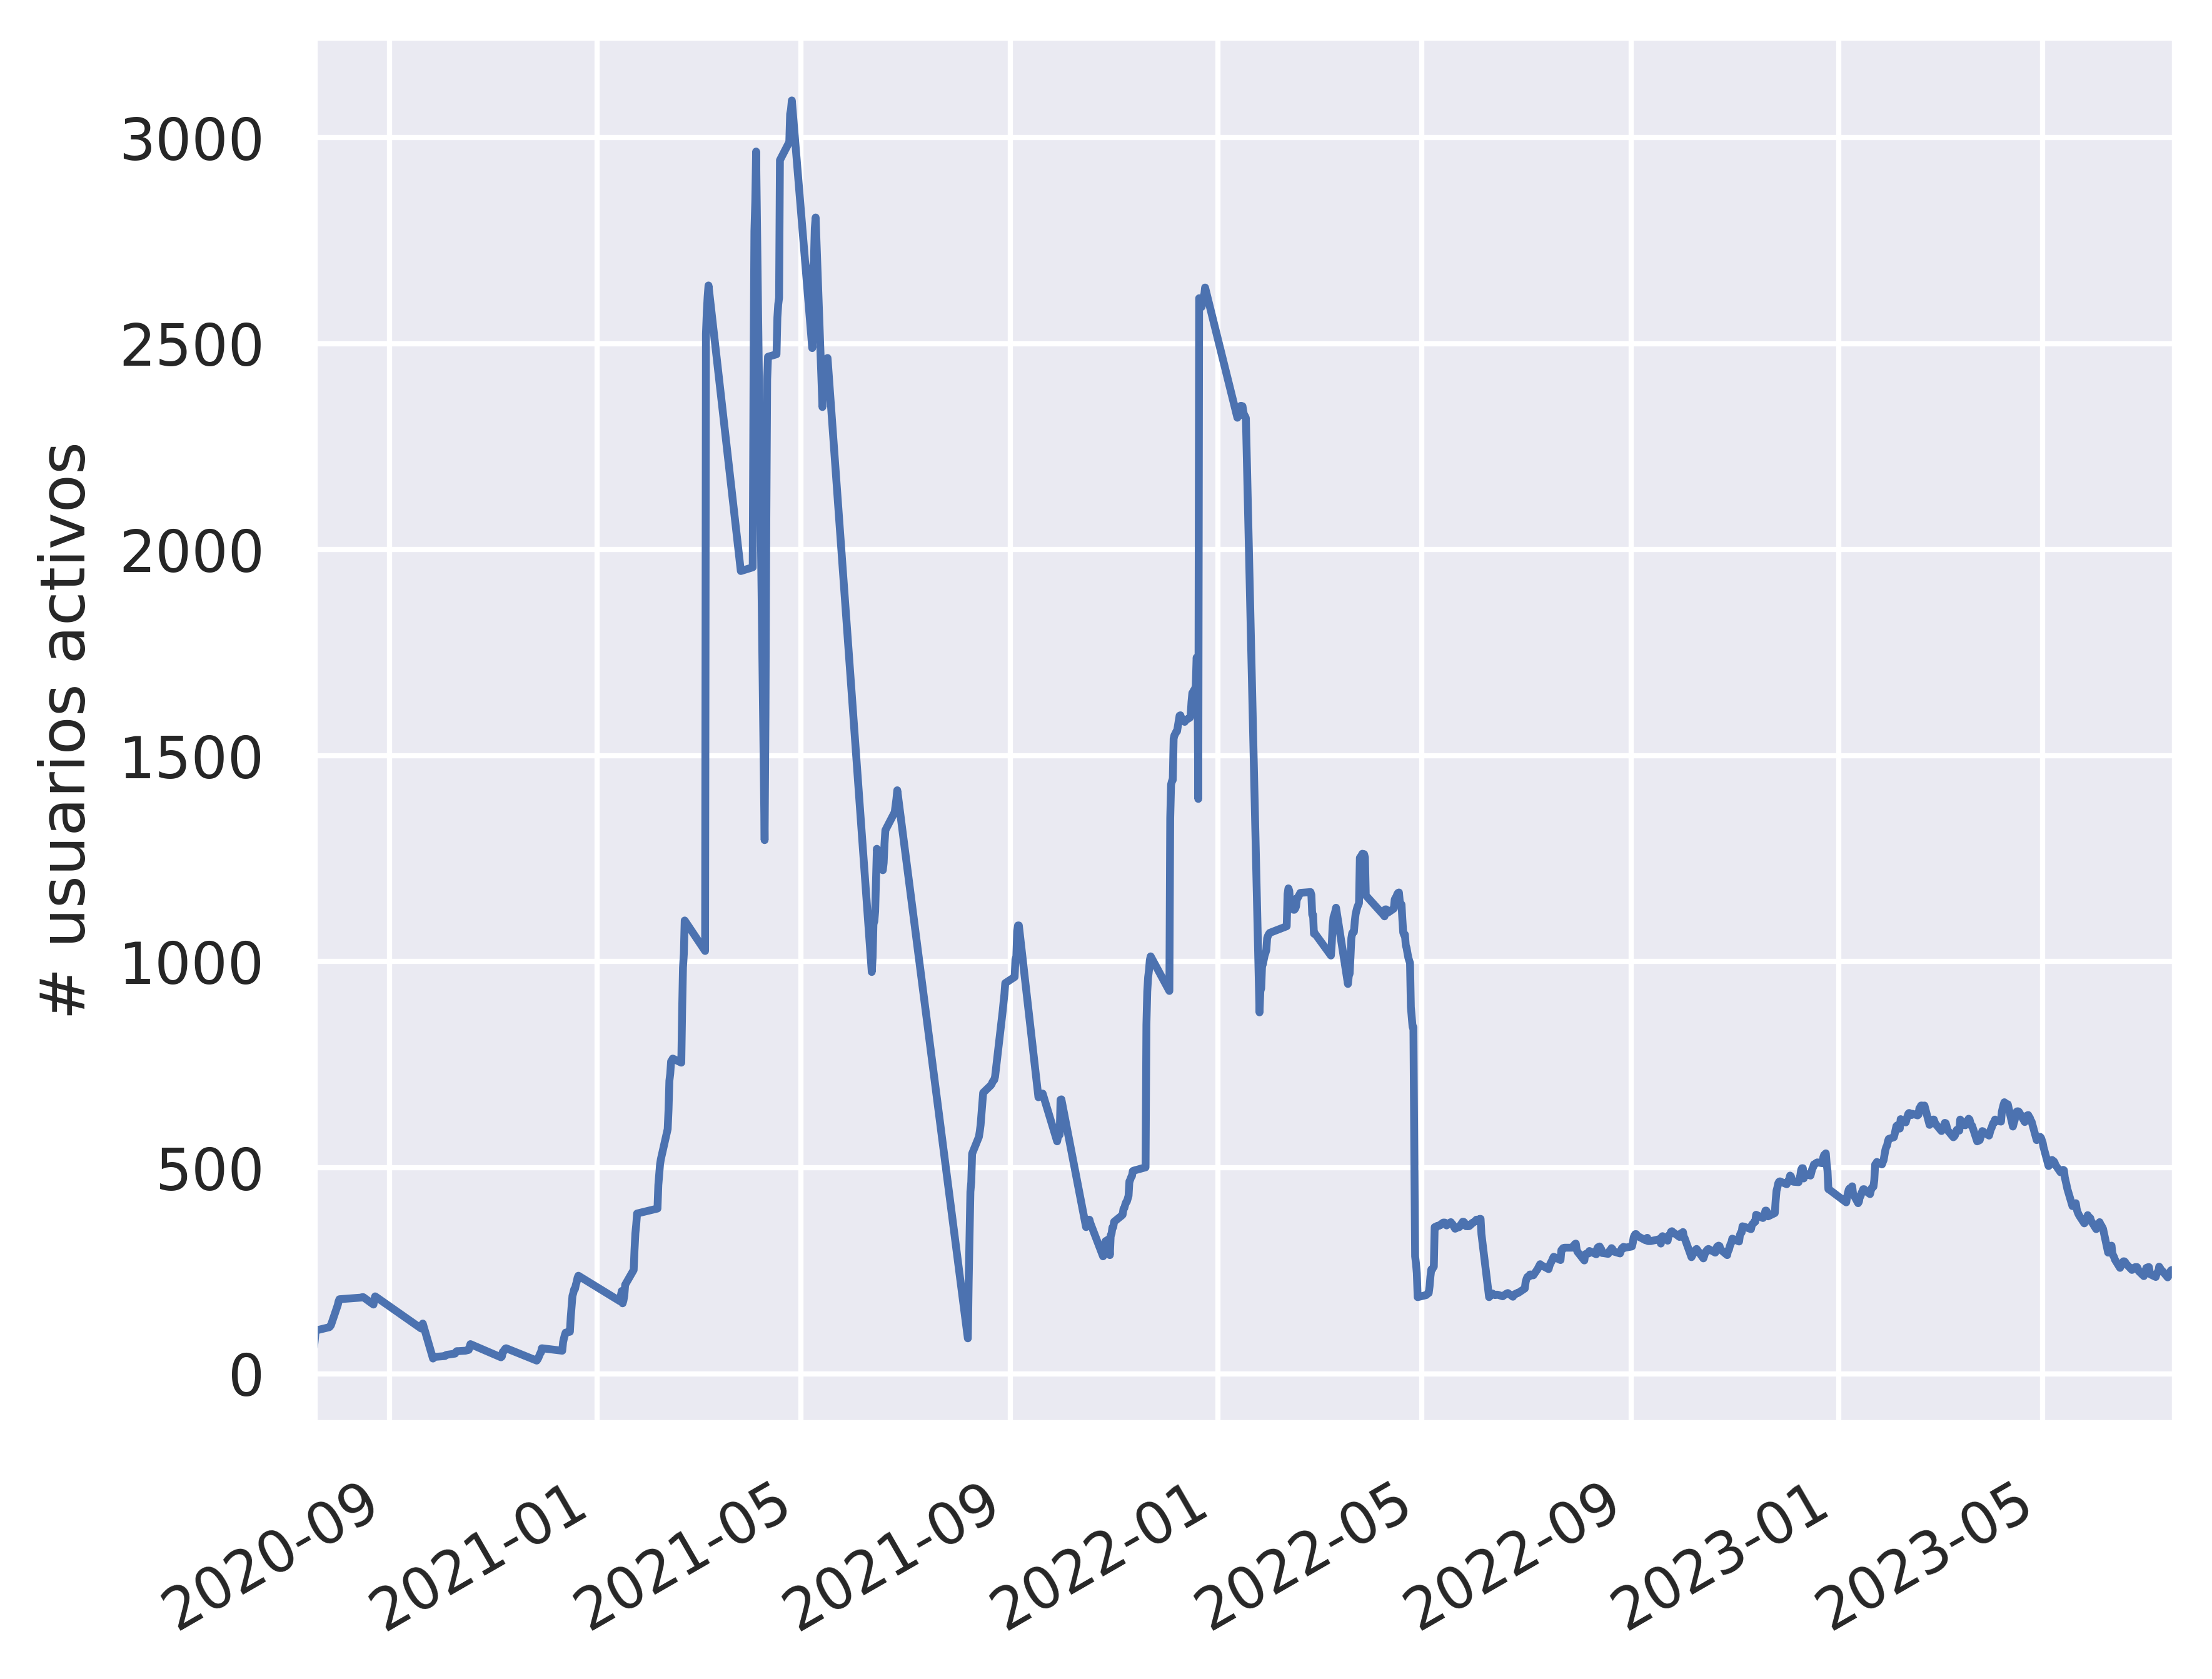

In [11]:
# import numba
from tqdm.autonotebook import tqdm
import rolling
import datetime as dt

tqdm.pandas(total=len(dfv))

# WINDOW_SIZE = '30D'
WINDOW_SIZE = dt.timedelta(days=30)

RESAMPLE_FREQ = '12h'

# @numba.jit(nopython=True)
# def nunique(arr):
#     return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
# dfv['ucode'] = dfv['voter'].cat.codes
#_cnt = dfv.set_index('date').sort_index().rolling(WINDOW_SIZE)['ucode'].progress_apply(nunique, raw=True).rename('cnt')

# Al final resulta que lo mejor era ir a por la solución O(1)
_voters = dfv.set_index('date').sort_index()['voter'] # .cat.codes
r = tqdm(
    rolling.arithmetic.Nunique(_voters.items(), WINDOW_SIZE, window_type='indexed'),
    total=len(dfv),
)
_cnt = pd.Series(r, index=_voters.index)
# Need to resample or there would be too many points
_cnt = _cnt.resample(RESAMPLE_FREQ).max()

print(dfv['date'].min(), dfv['date'].max())
ax = sns.lineplot(_cnt)
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# usuarios activos')
plt.xlim(dfv['date'].min(), dfv['date'].max())
nbutils.download_matplotlib(ax.figure, f'04c_rolling_voters_{WINDOW_SIZE}_{ORG_NAME}.png')

## Cuando se unen los usuarios

Es decir, cuando votan por primera vez

Cannot show ipywidgets in text

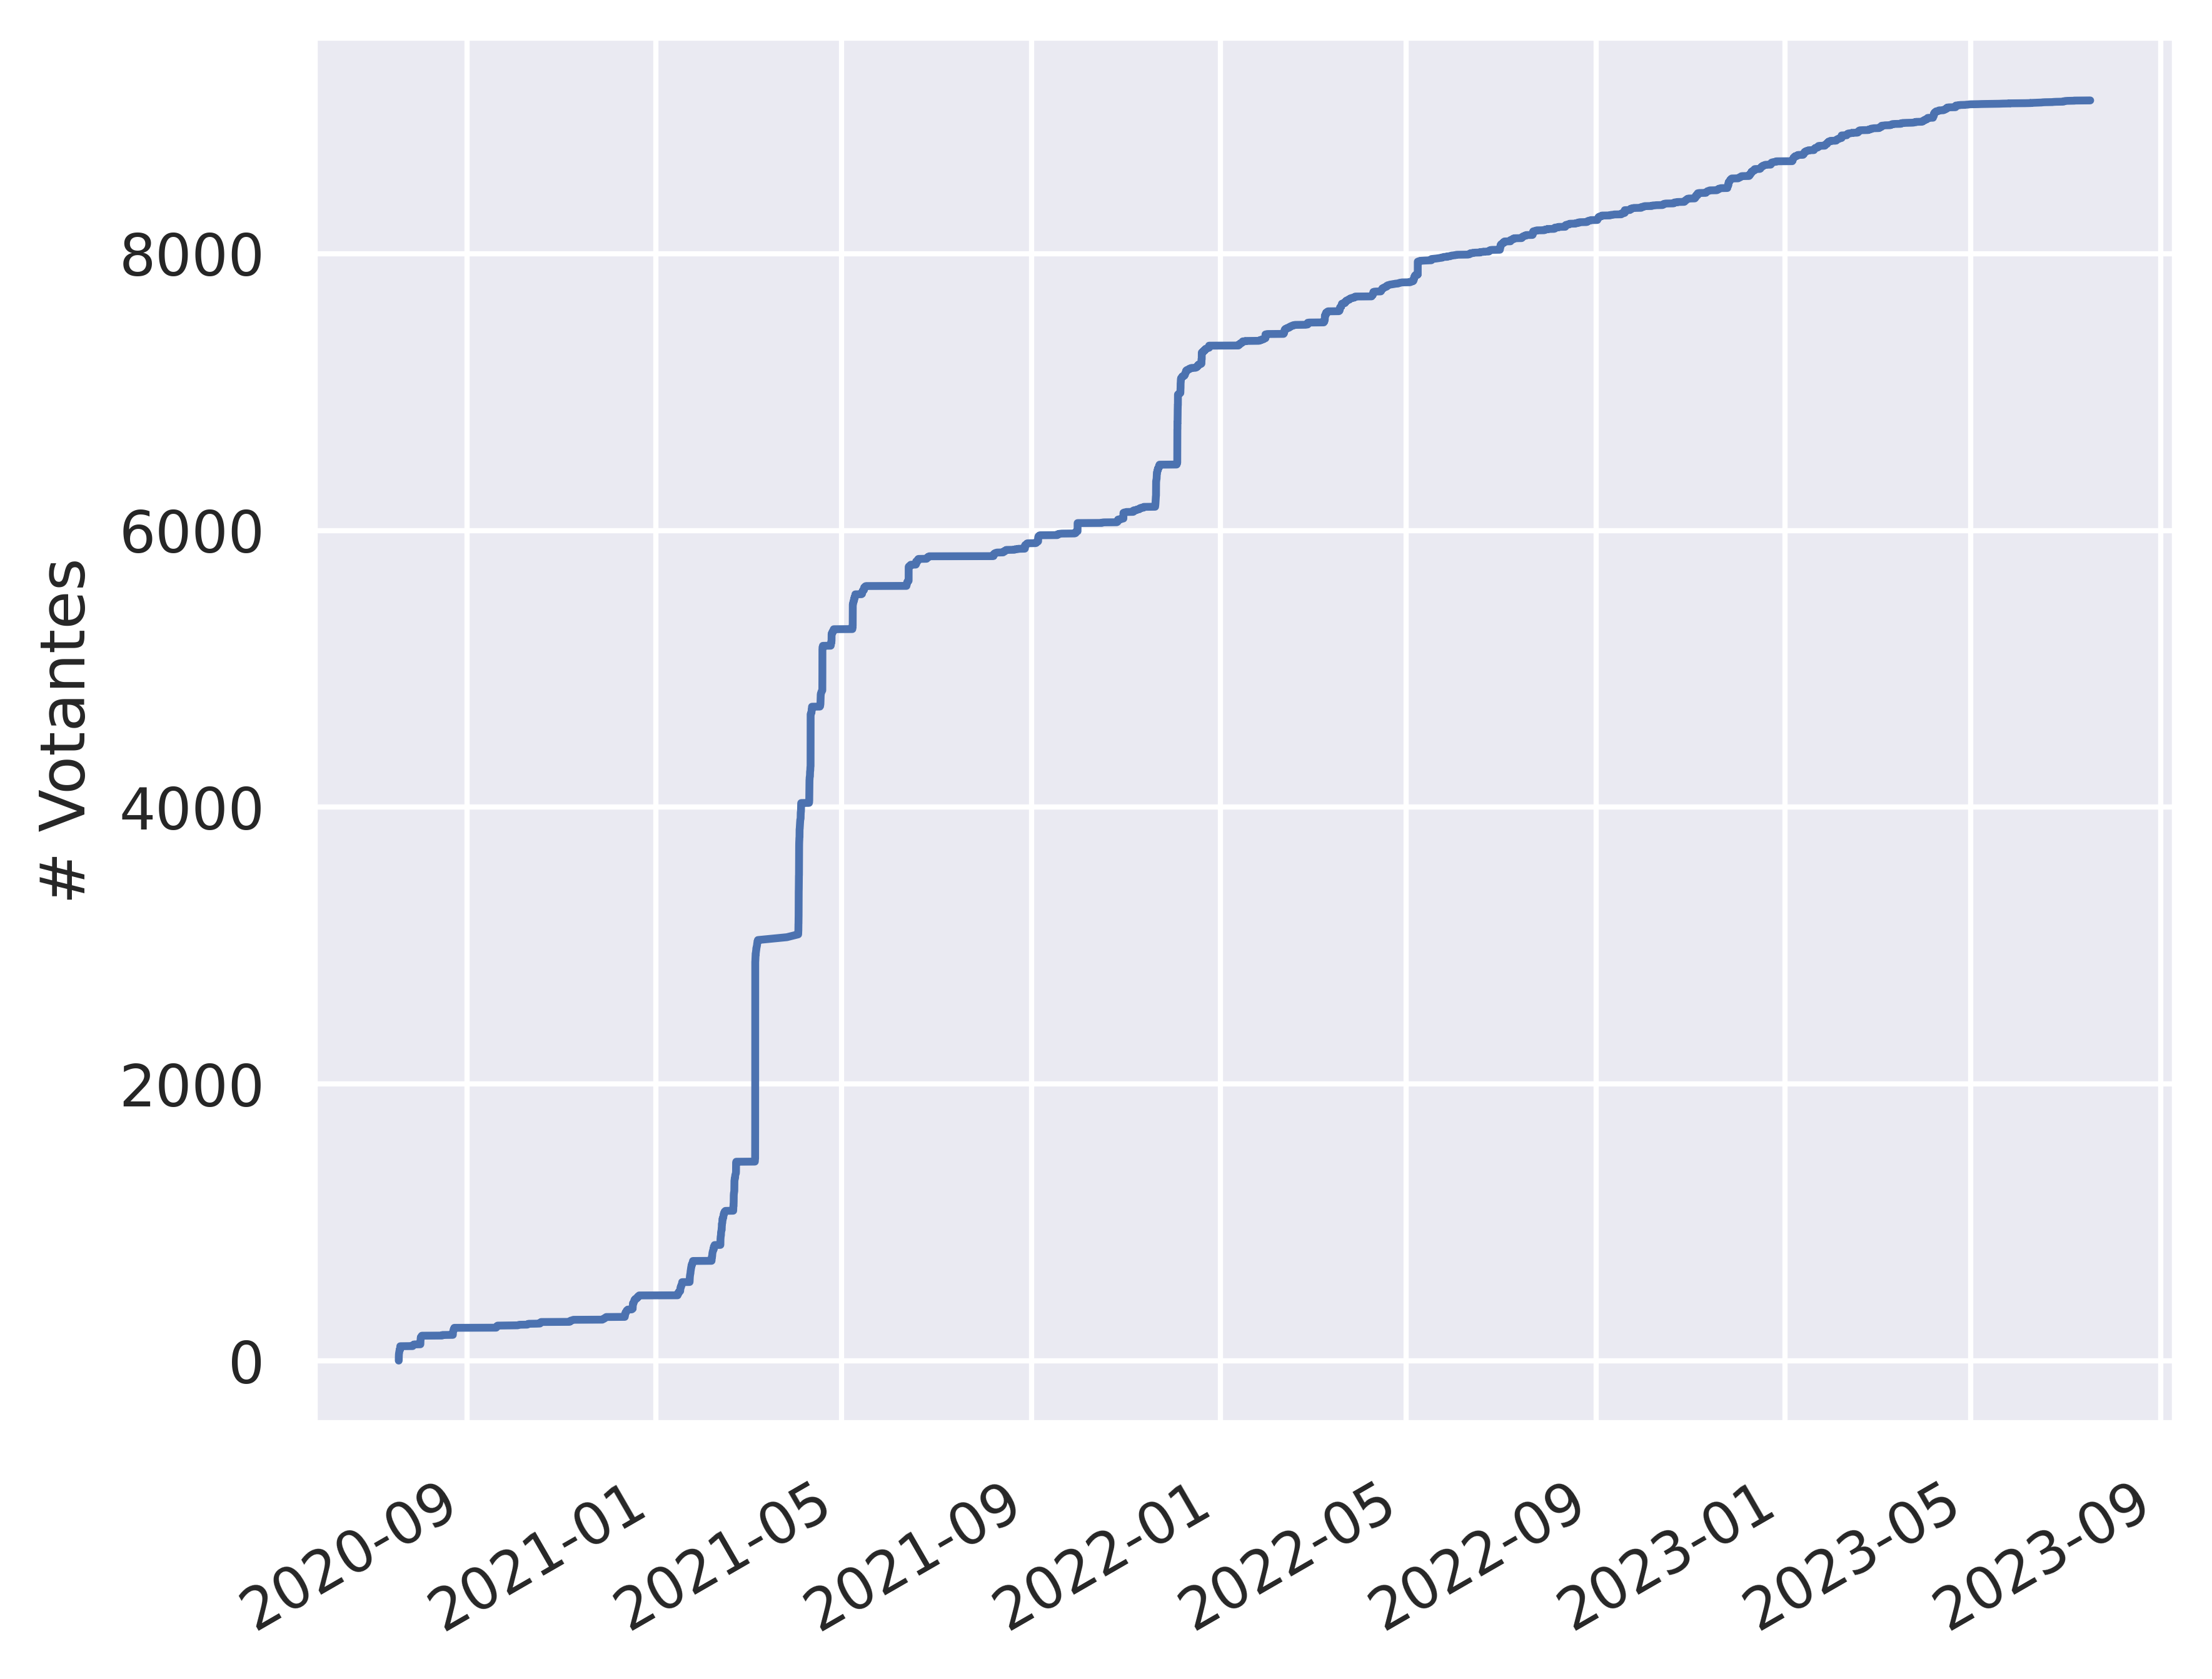

In [12]:
_toplot = dfv.groupby('voter')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Votantes')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_cumcnt_users_{ORG_NAME}.pdf')

## Cuando se crean las propuestas

Cannot show ipywidgets in text

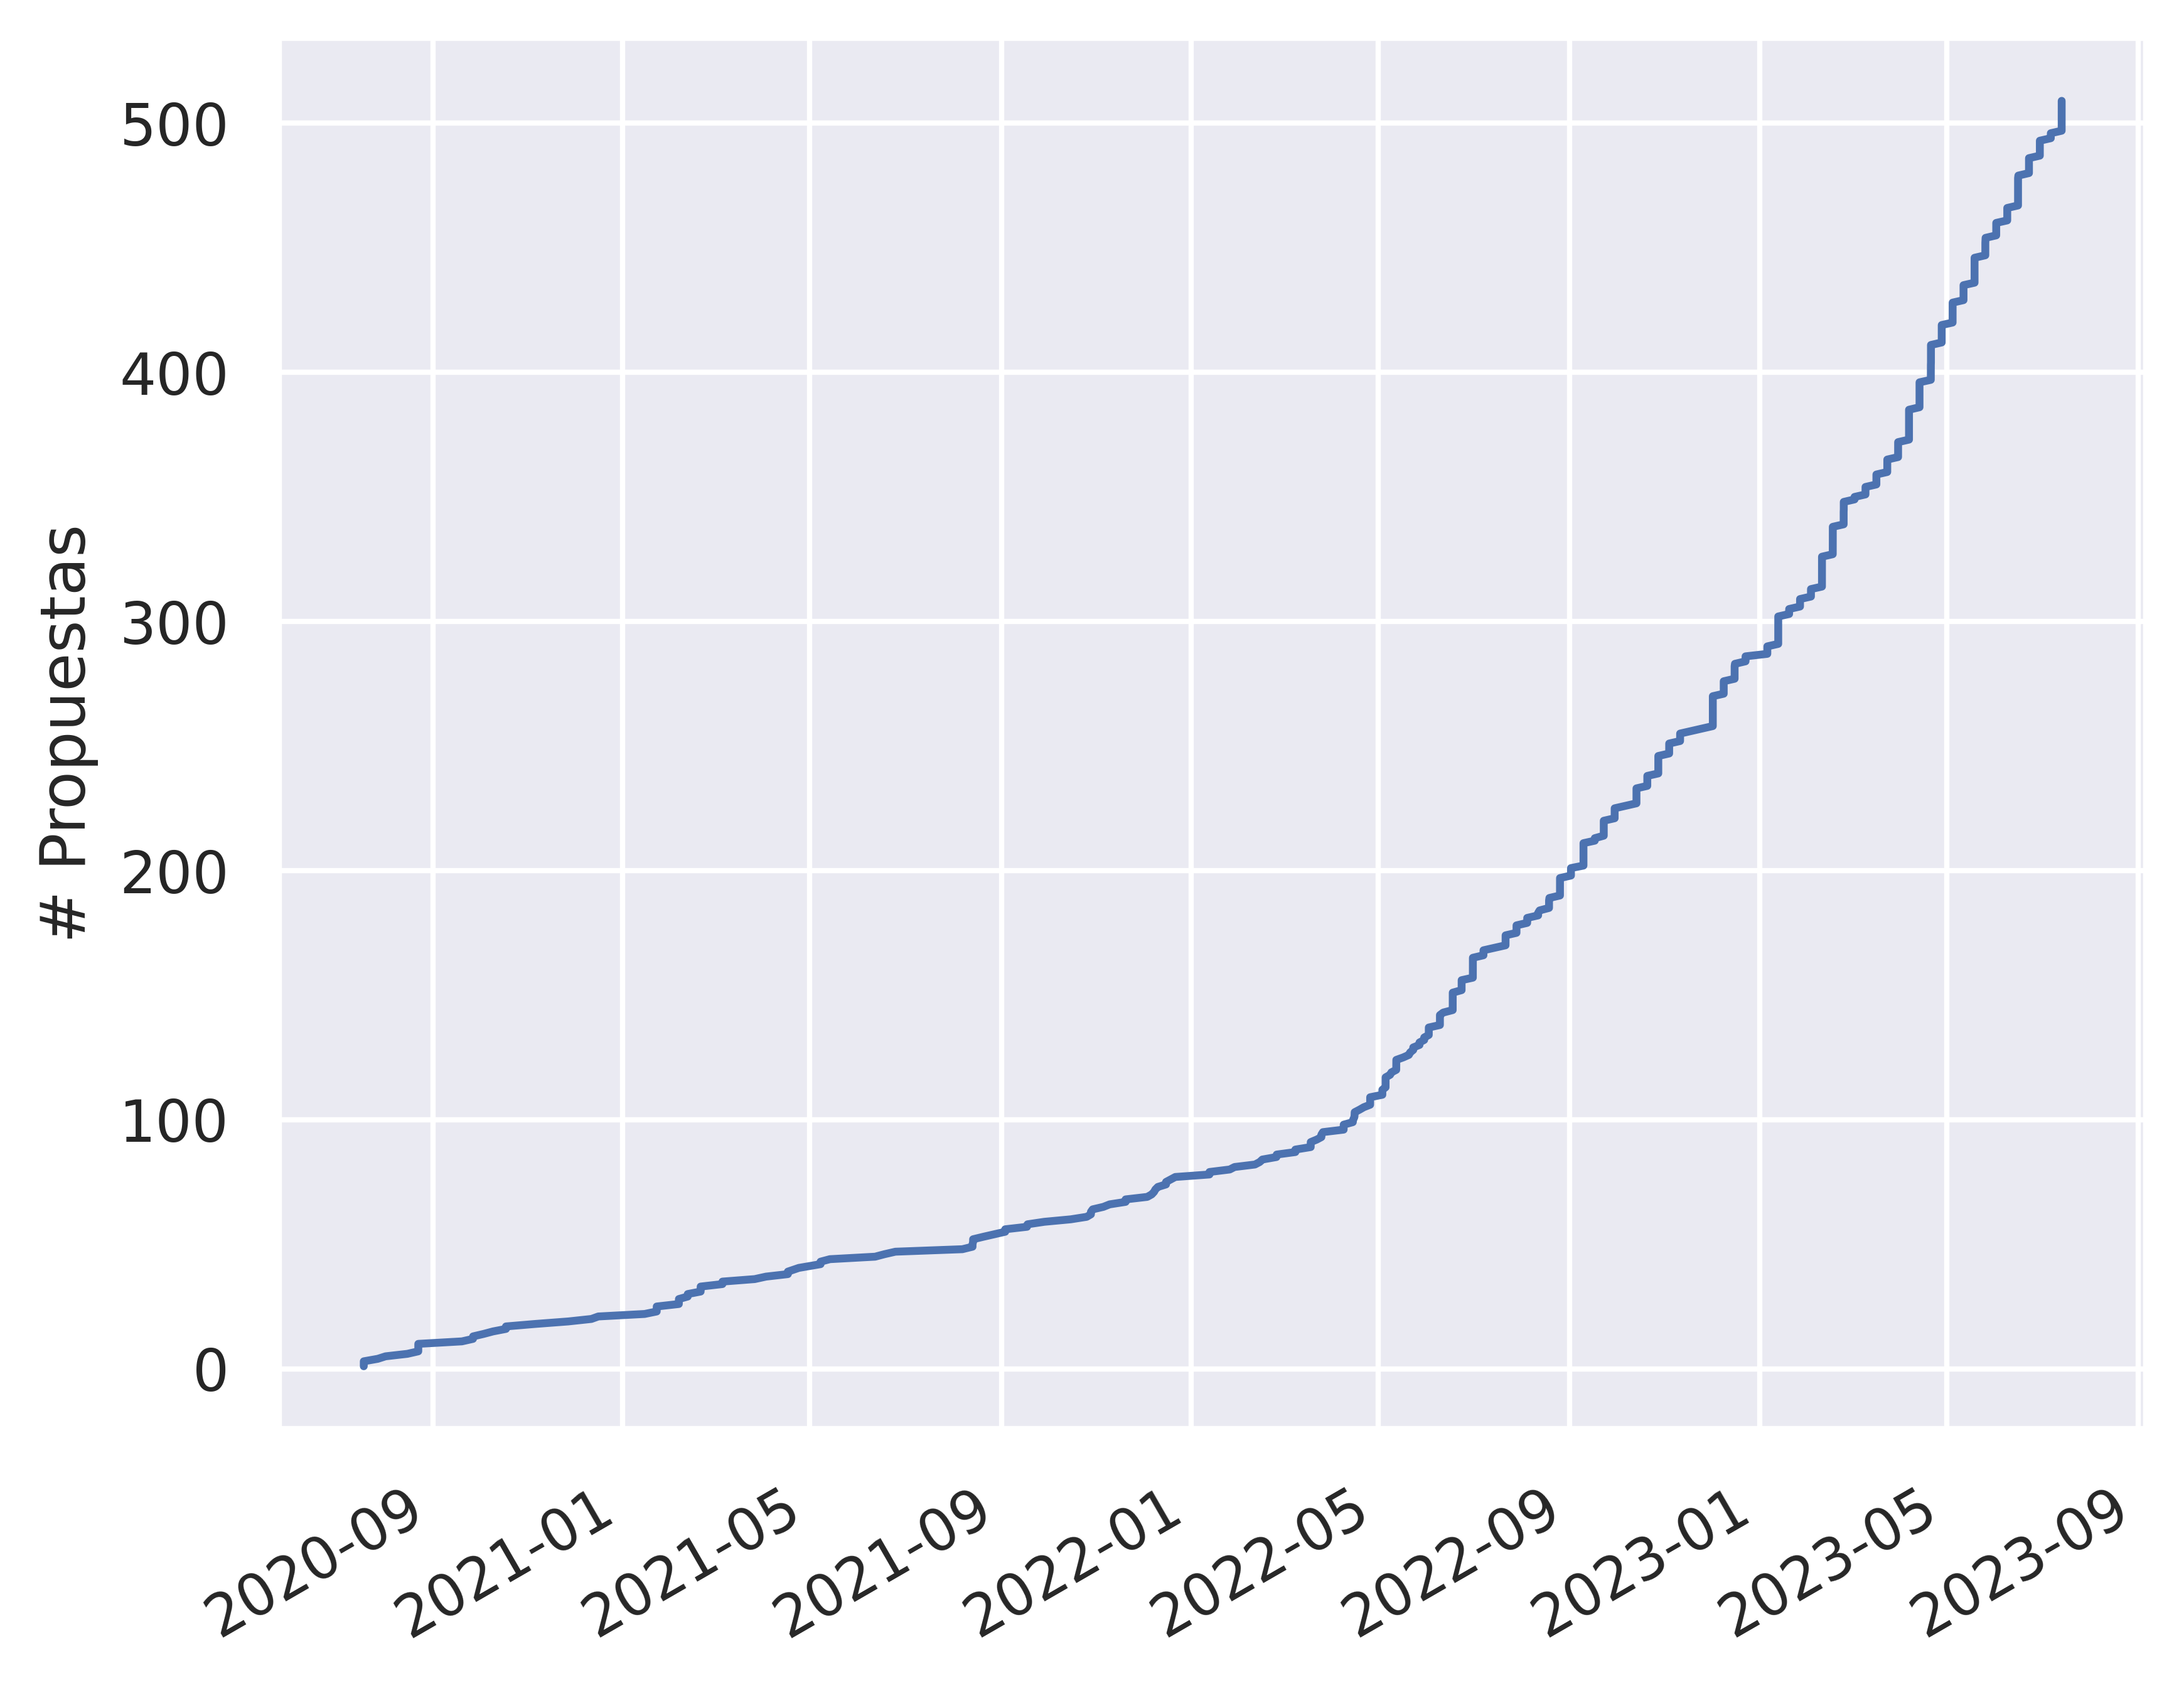

In [13]:
_toplot = dfv.groupby('proposal')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Propuestas')

nbutils.download_matplotlib(ax.figure, f'04c_cumcnt_users_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

<Figure size 3840x2880 with 0 Axes>

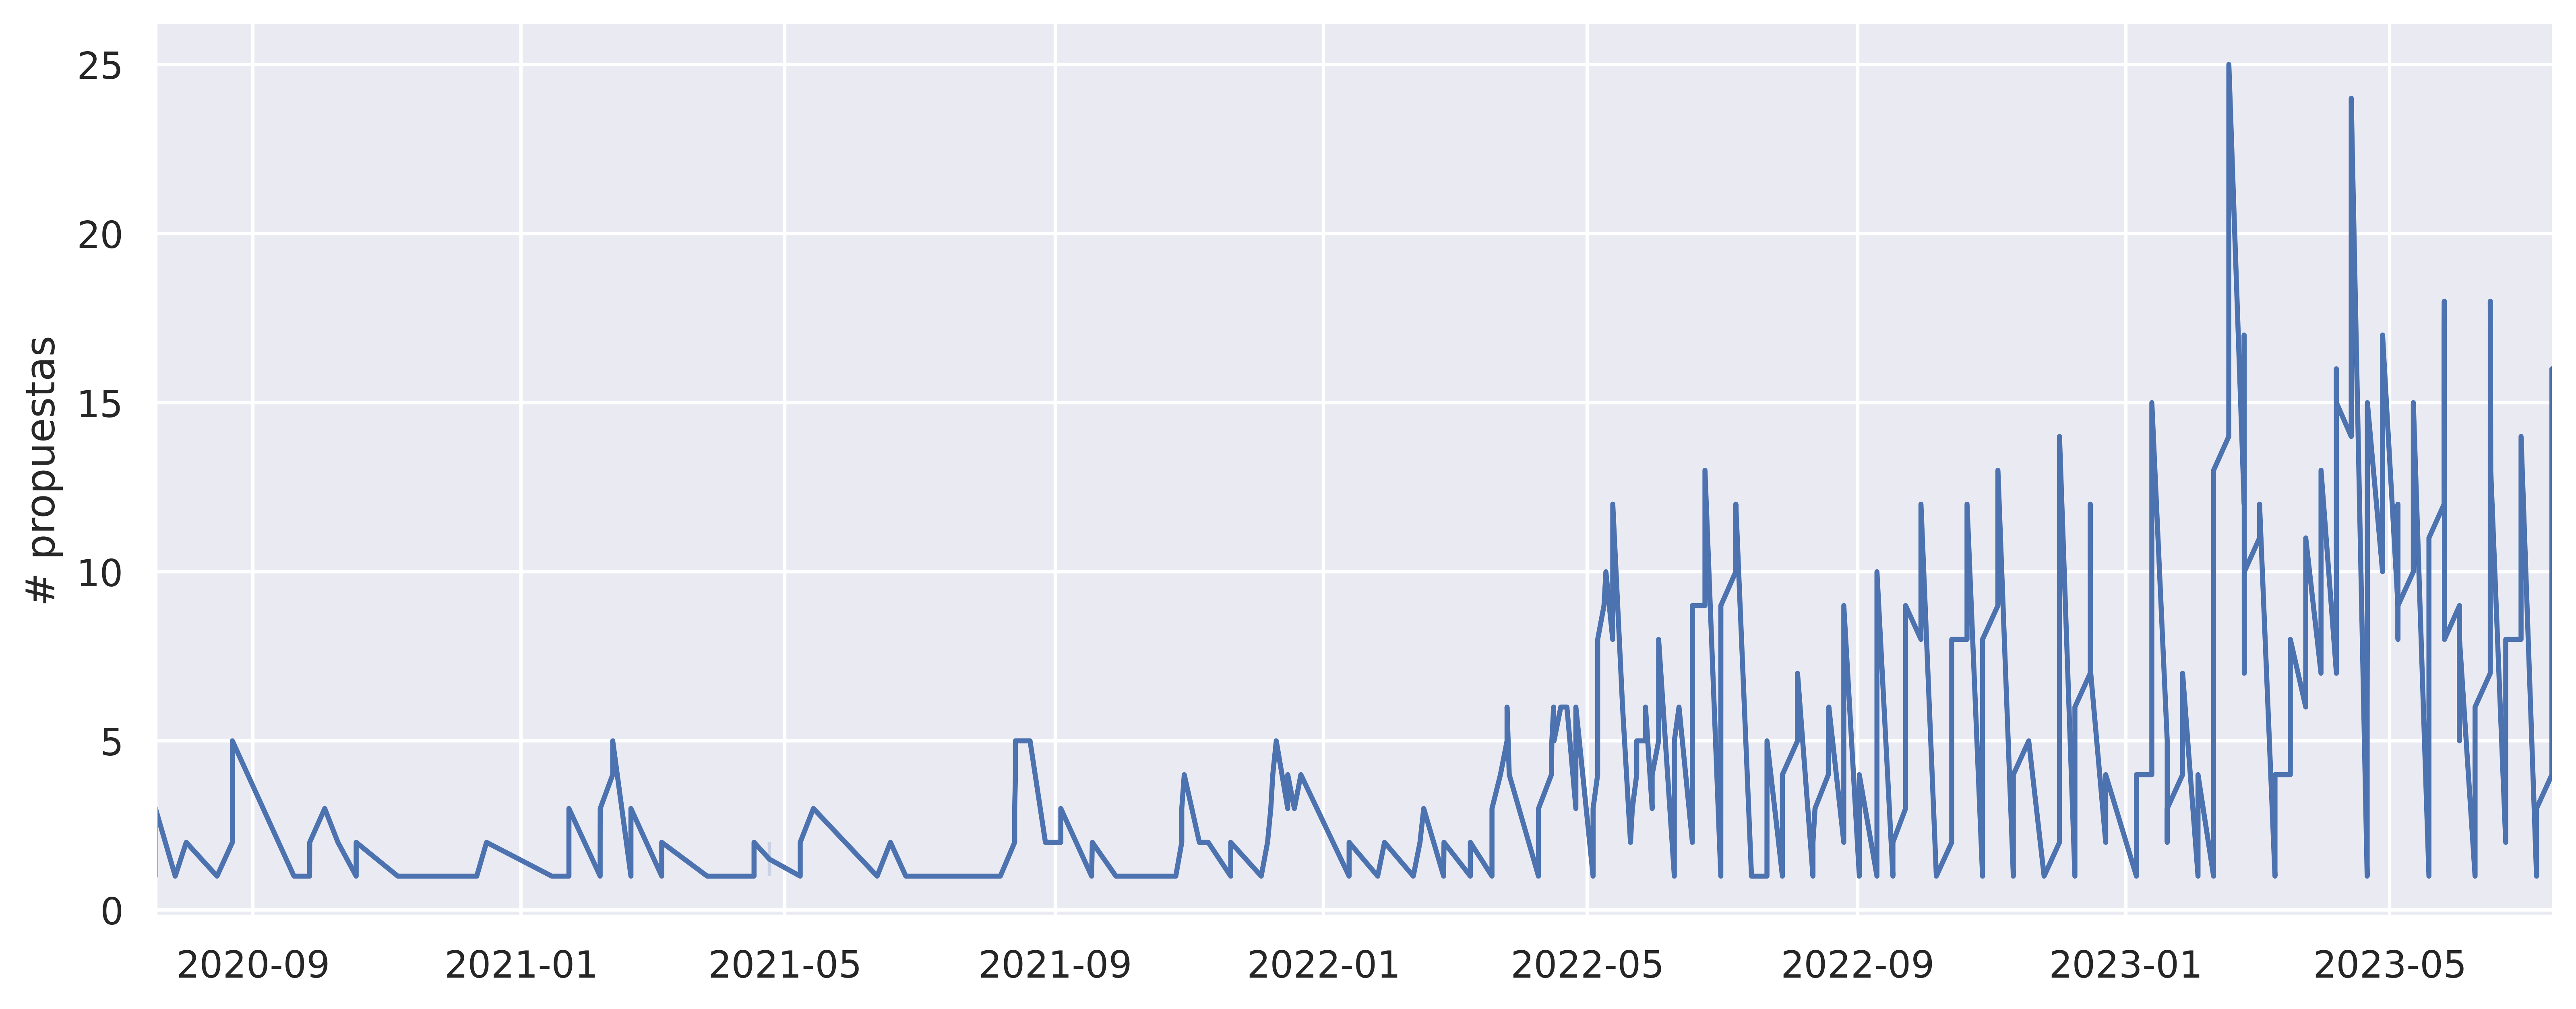

In [14]:
WINDOW_SIZE = '7D'

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=(fs[0]*2, fs[1]))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()
nbutils.download_matplotlib(ax.figure, f'04c_rolling_proposals_{WINDOW_SIZE}_{ORG_NAME}.pdf')

## Dia de la semana en que se votan las propuestas

> incluso, se podría hacer un heatmap X cuando se lanzan Y cuando se votan y Z (color) la frecuencia
> -- Javi

Vamos, que en esta celda vamos a intentar hacer un HEATMAP donde:
- X: dia de la semana de creación de la propuesta
- Y: dia de la semana de votación
- Z: número de votos

In [15]:
_toplot.to_numpy()

array([[Timestamp('2020-07-18 16:12:04'), 1.0],
       [Timestamp('2020-07-18 16:12:18'), 2.0],
       [Timestamp('2020-07-18 16:15:59'), 3.0],
       ...,
       [Timestamp('2023-07-13 18:43:00'), 14.0],
       [Timestamp('2023-07-13 18:44:04'), 15.0],
       [Timestamp('2023-07-13 18:44:14'), 16.0]], dtype=object)

Text(277.49999999999994, 0.5, 'Día votación')

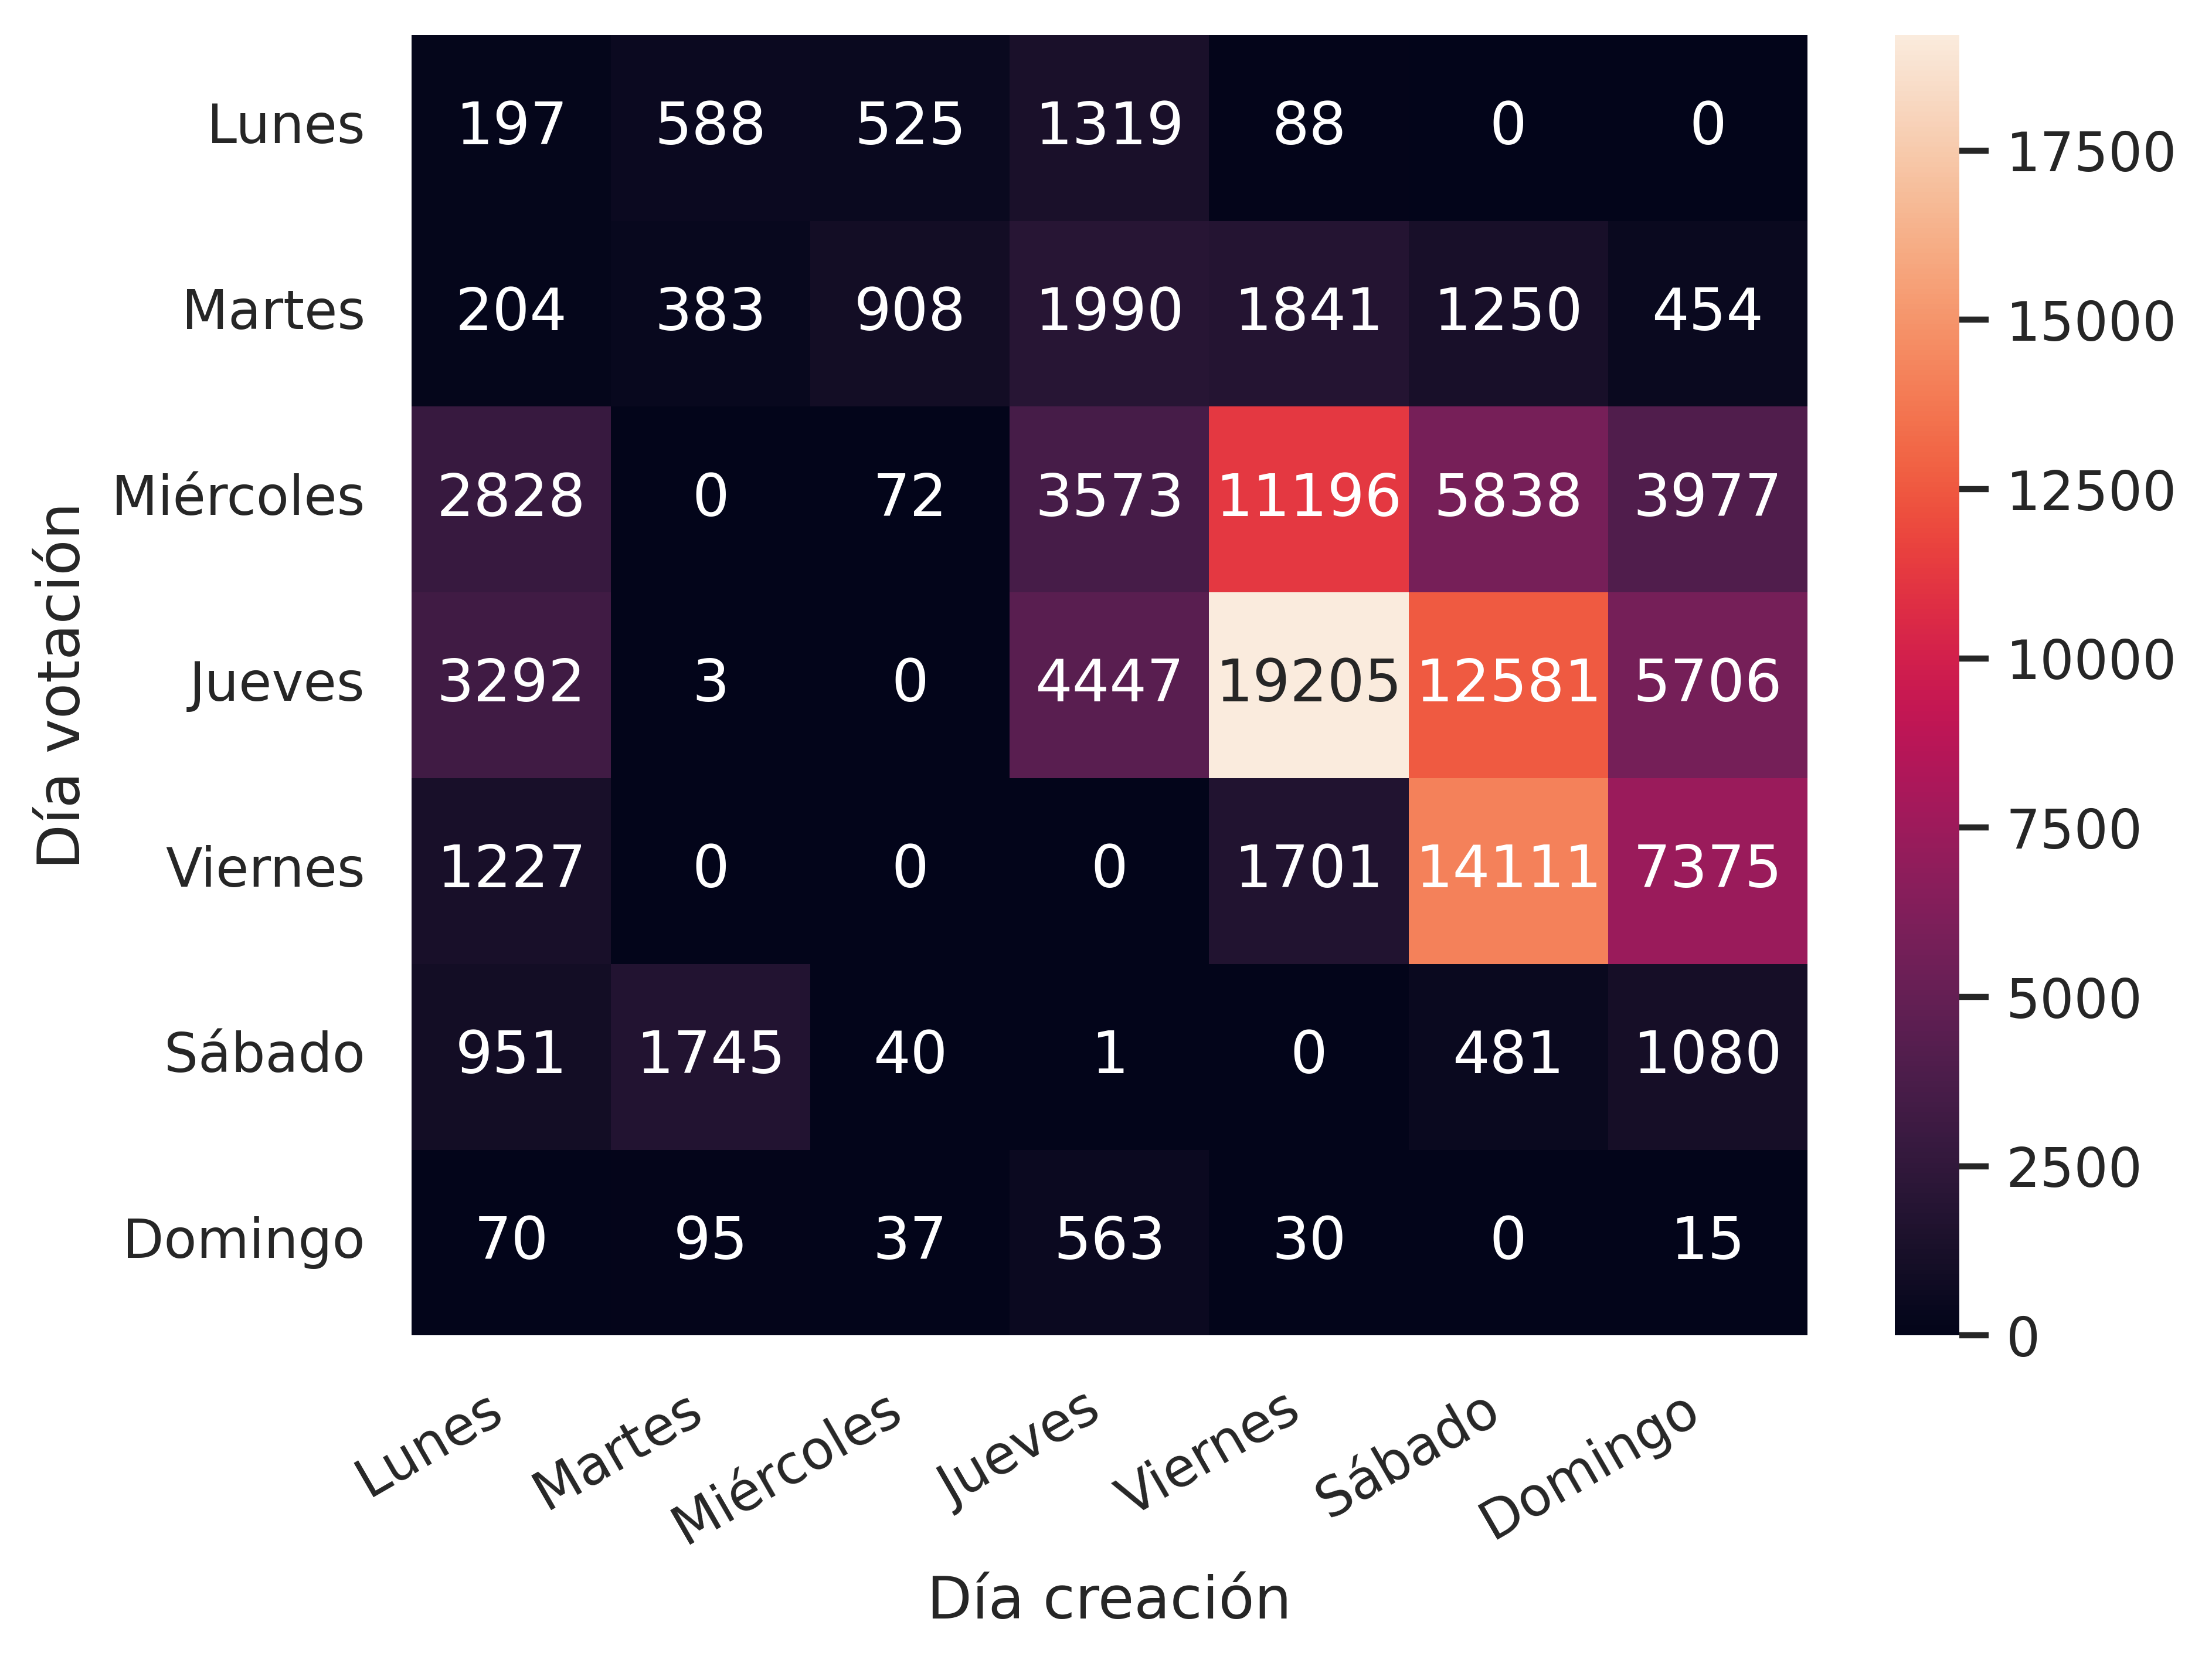

In [16]:
# In pandas, 0 = Monday
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

spanish_dow = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes', 
    5: 'Sábado',
    6: 'Domingo',
}

_dfvp = dfv.merge(dfp['date'].rename('proposal_date'), left_on='proposal', right_index=True)
_dfvp['date_dow'] = _dfvp['date'].dt.day_of_week
_dfvp['proposal_date_dow'] = _dfvp['proposal_date'].dt.dayofweek
# sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
_toplot = pd.crosstab(_dfvp['proposal_date_dow'], _dfvp['date_dow']).rename(index=spanish_dow, columns=spanish_dow)

sns.heatmap(_toplot, annot=True, fmt='g')
plt.xticks(rotation=30, ha='right')

plt.xlabel('Día creación')
plt.ylabel('Día votación')

Cannot show ipywidgets in text

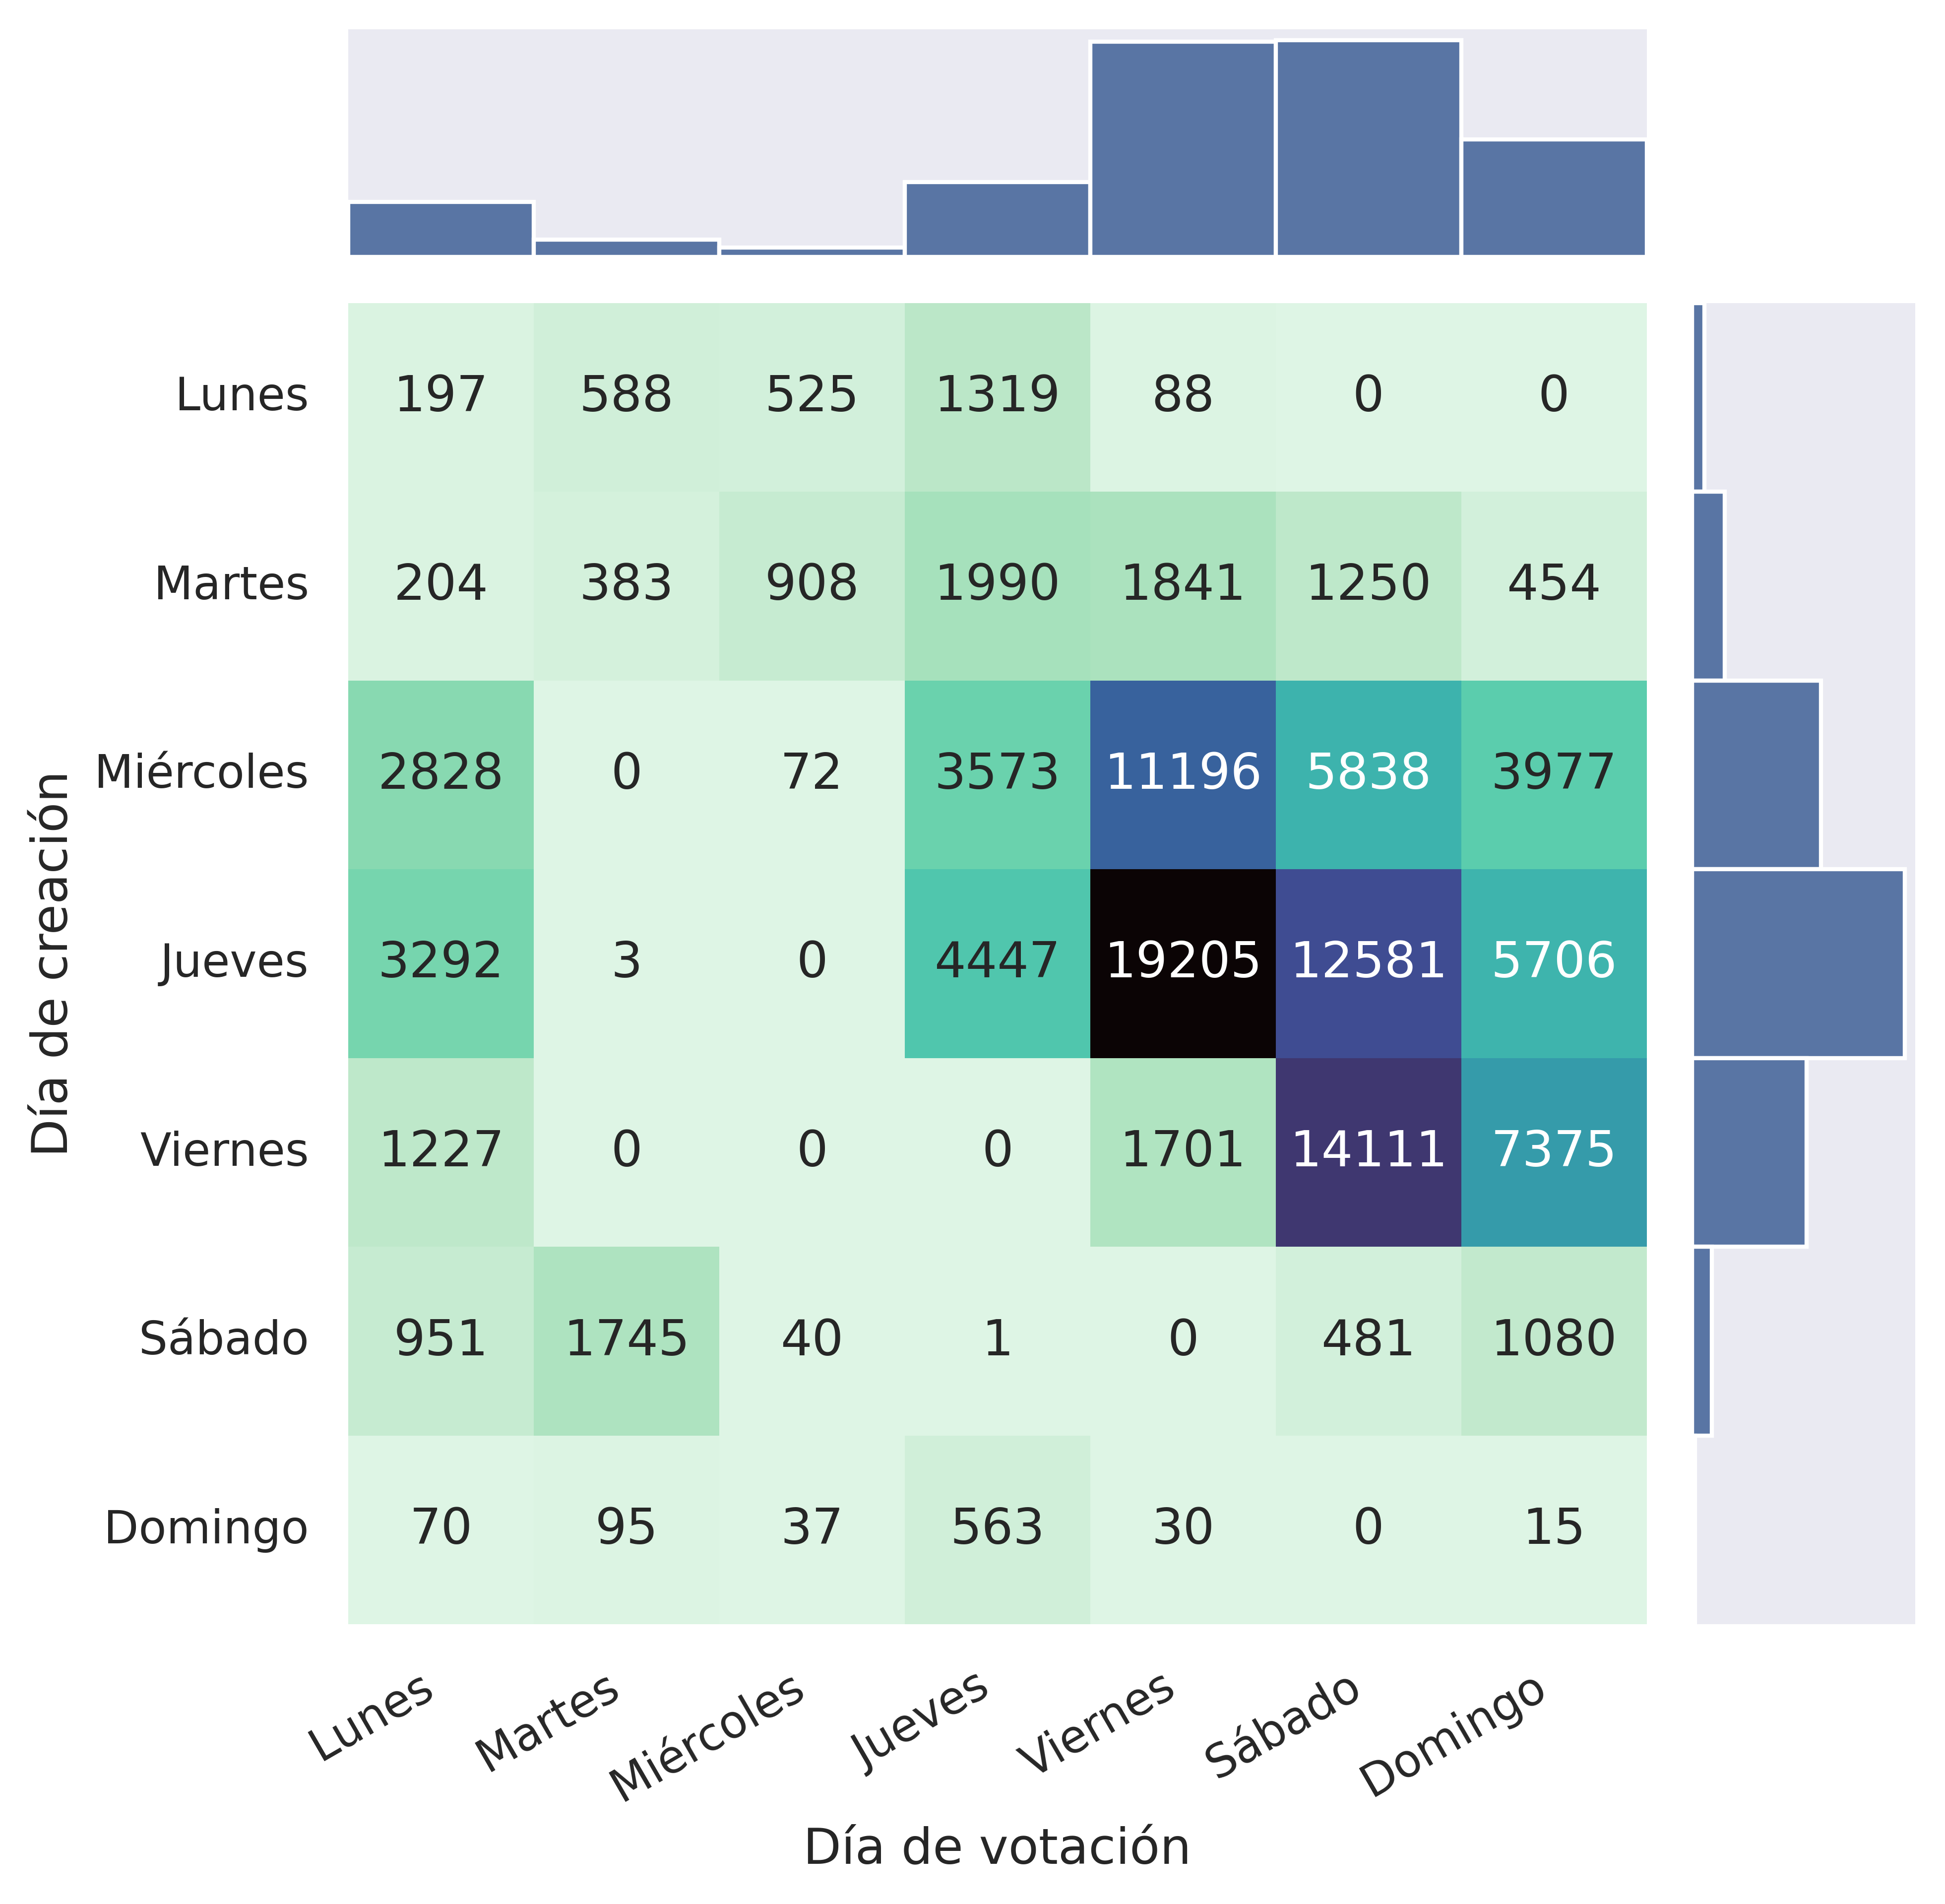

In [17]:
# _toplot = pd.crosstab(...)

grid = sns.JointGrid()

sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt='g', cmap='mako_r')
sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=1)
sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=1)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

grid.ax_joint.set_xticklabels(grid.ax_joint.get_xticklabels(), rotation=30, ha='right')
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Día de votación')
grid.ax_joint.set_ylabel('Día de creación')

nbutils.download_matplotlib(grid, f'04c_heatmap_proposals_{ORG_NAME}.pdf')

<Axes: xlabel='proposal_date_dow', ylabel='count'>

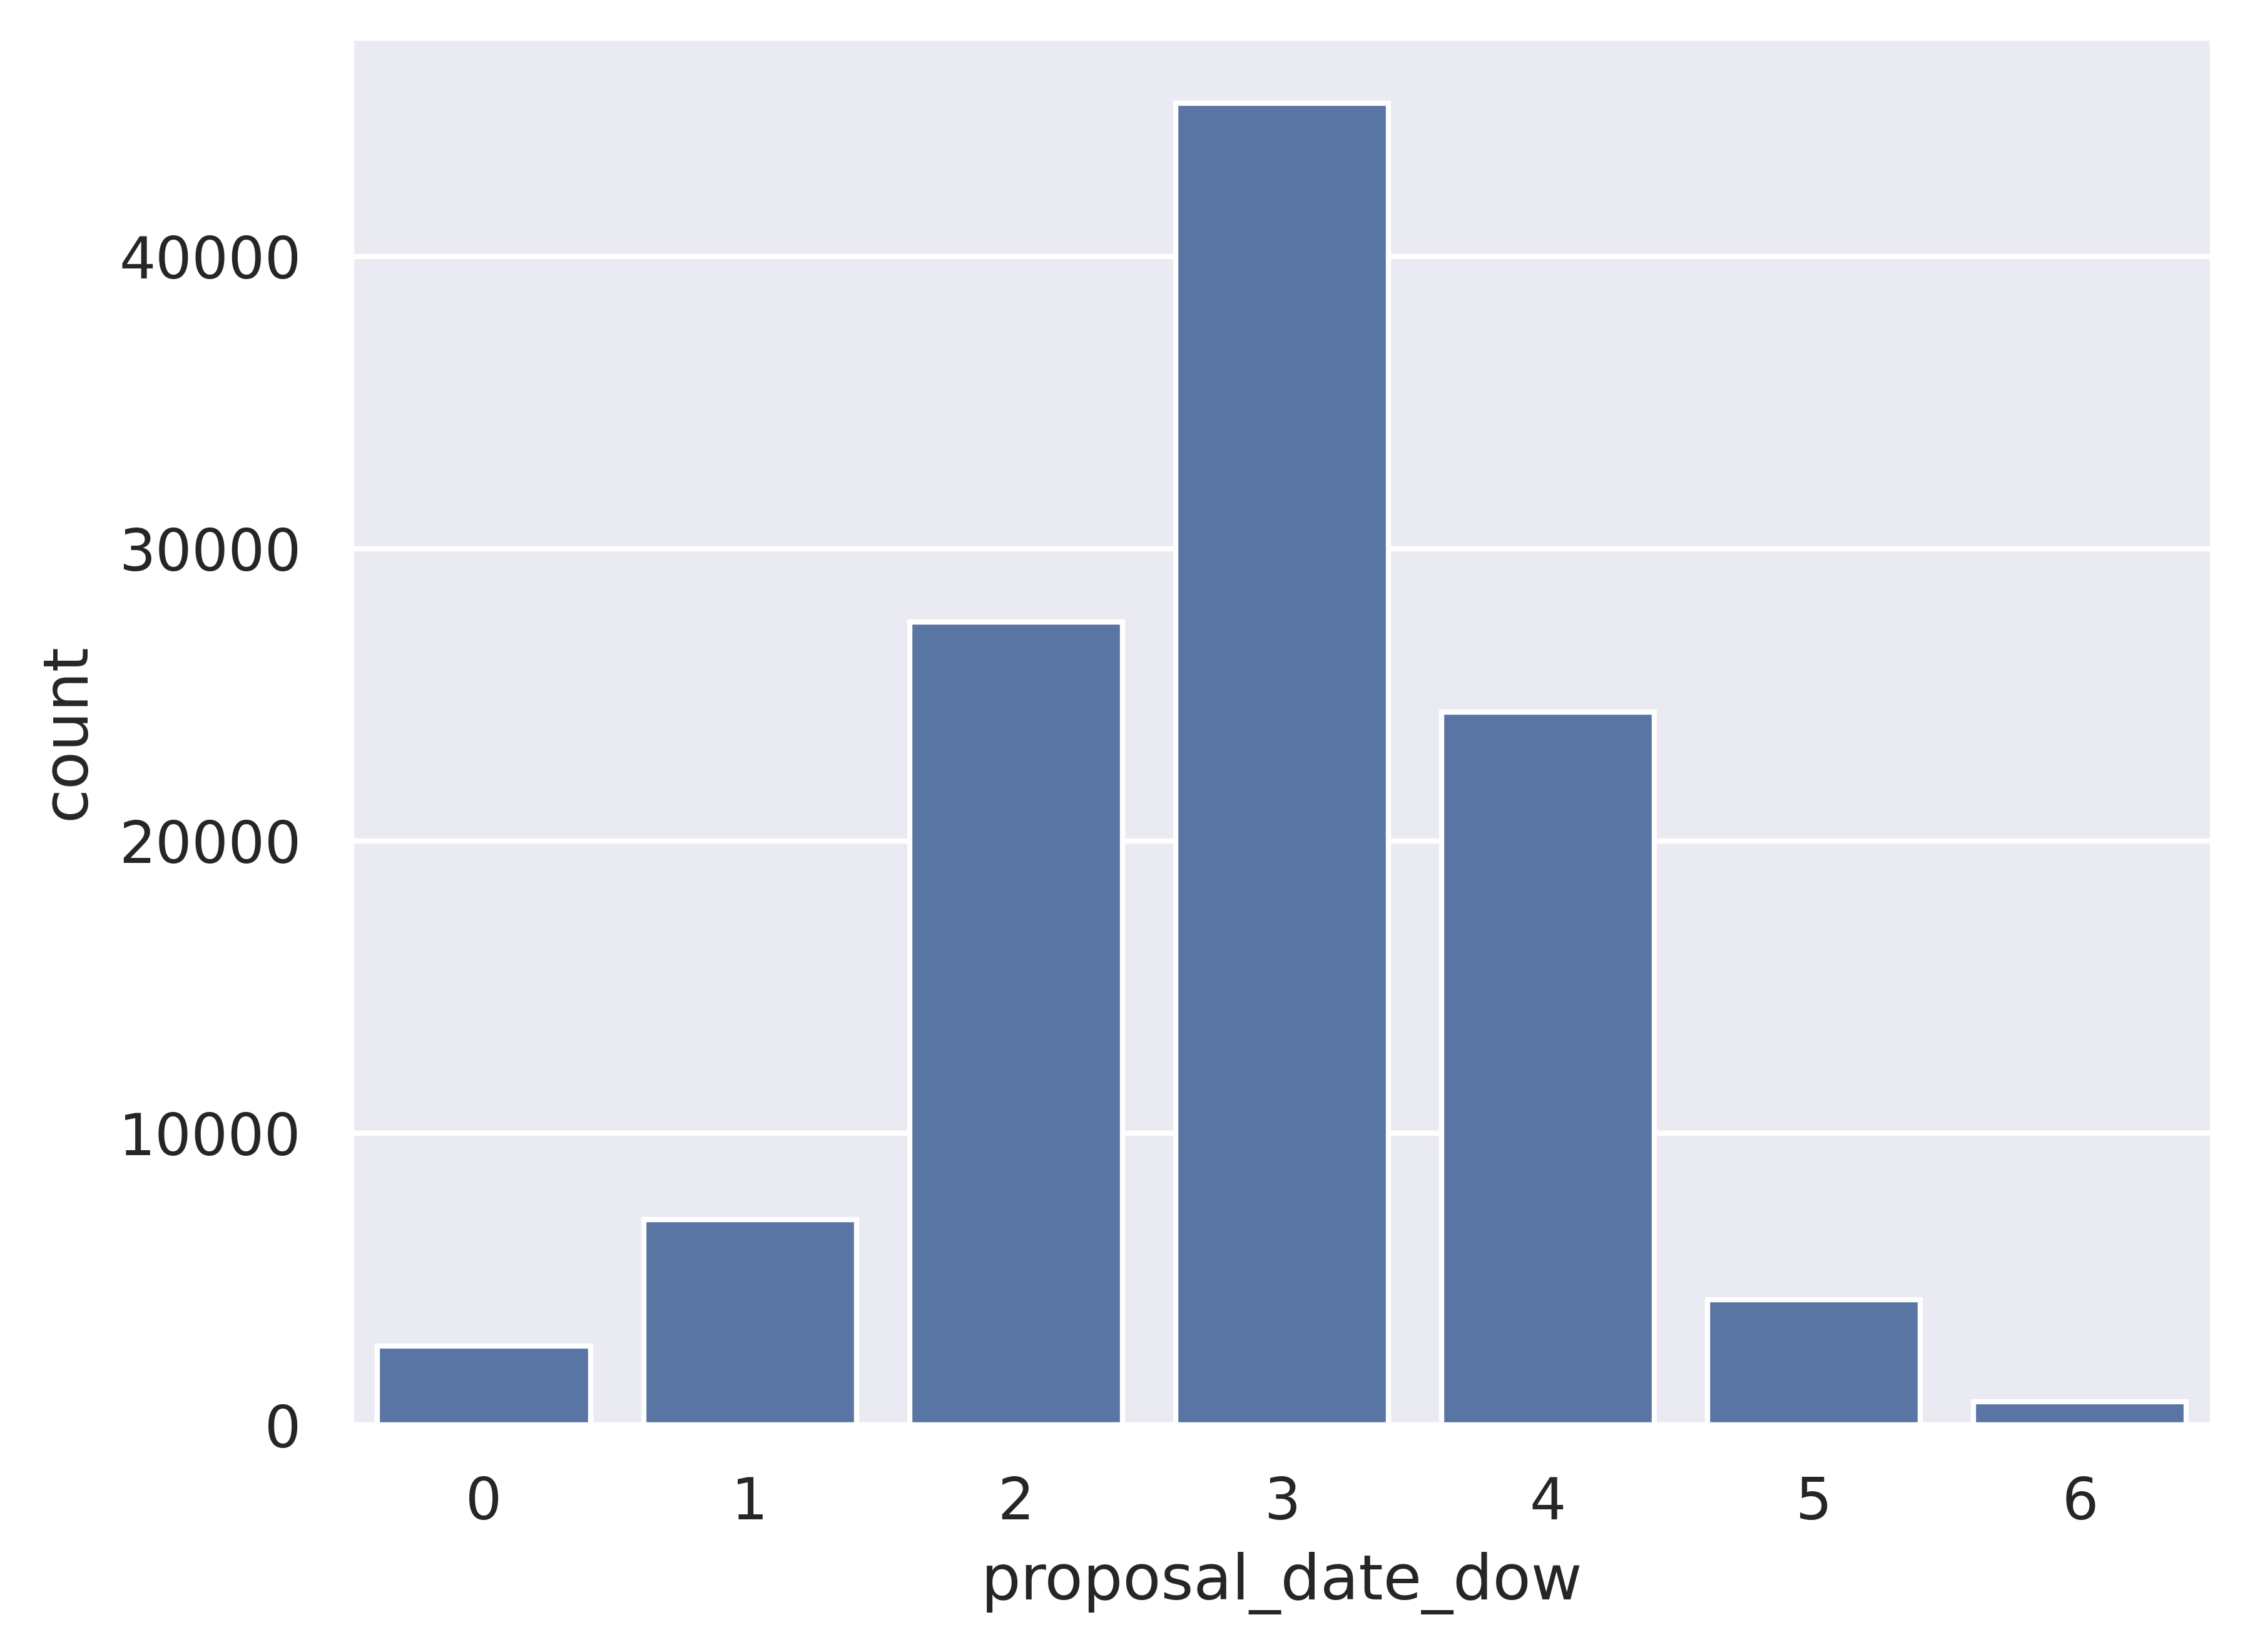

In [18]:
sns.countplot(_dfvp, x='proposal_date_dow')

<Axes: xlabel='count', ylabel='date_dow'>

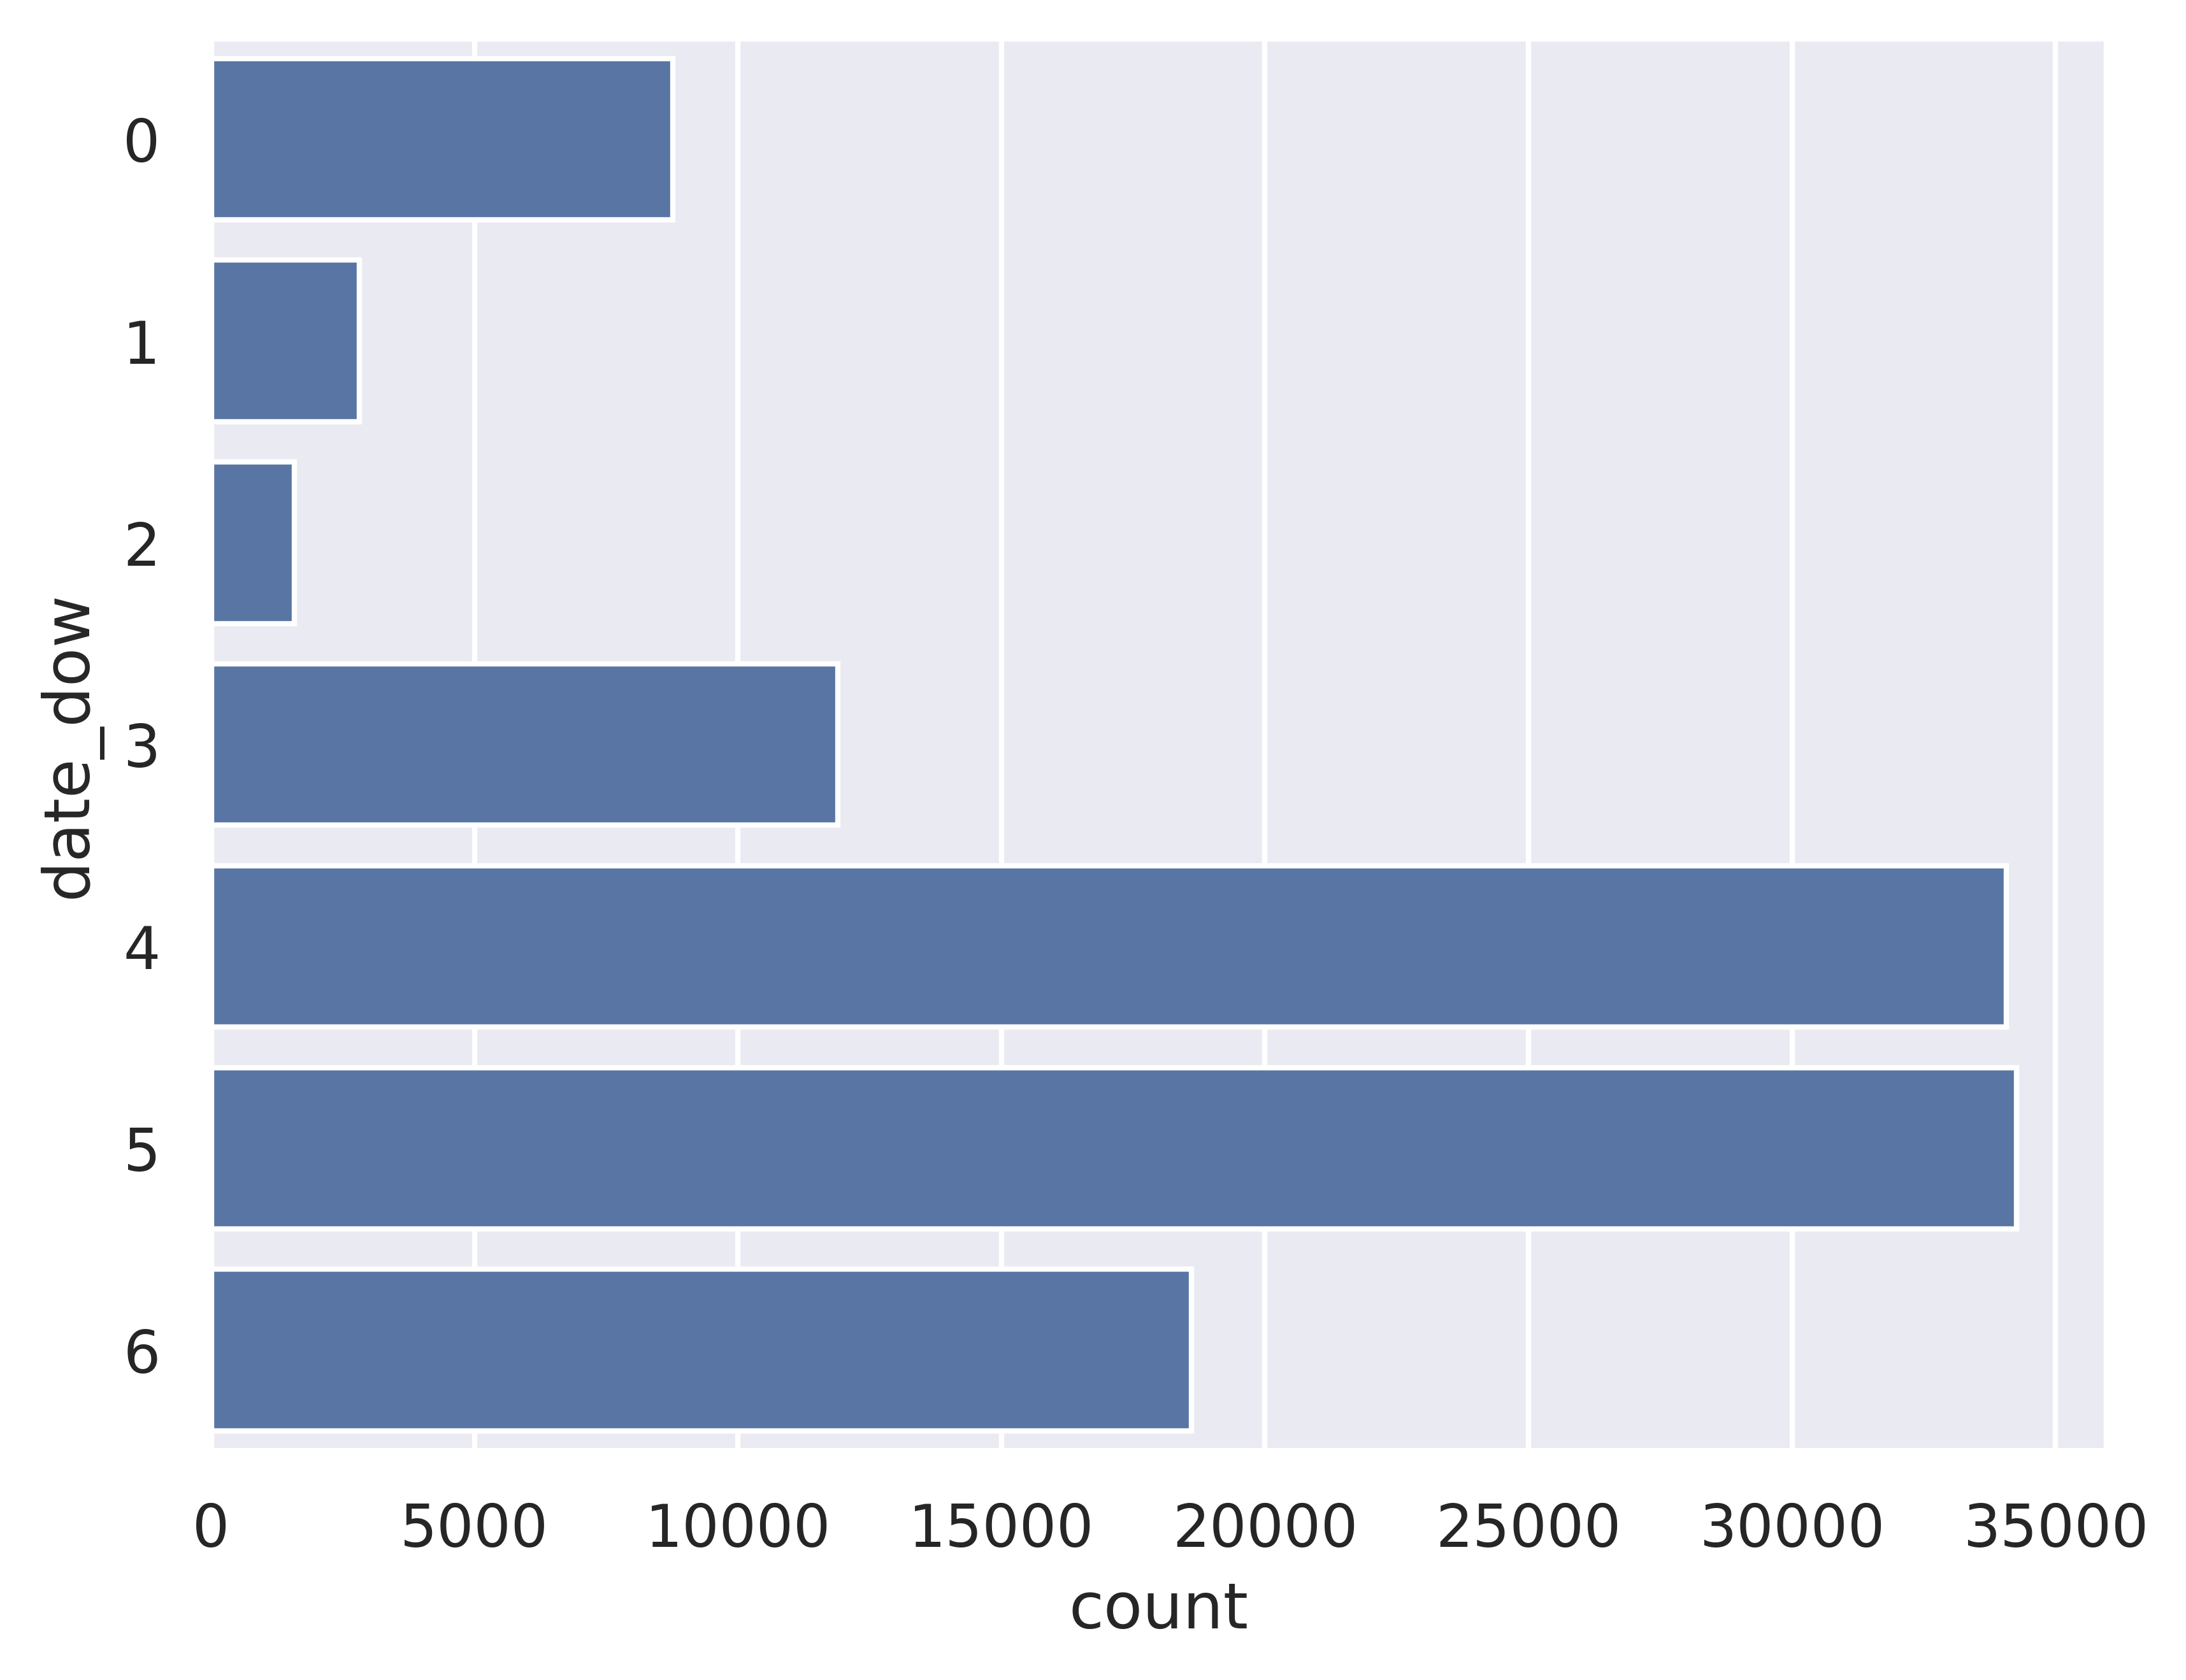

In [19]:
sns.countplot(_dfvp, y='date_dow')

## Suelen votarse las propuestas al principio o al final

In [20]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Histograma de tiempo de los votos en la propuesta {proposal}")
    return ax

# proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

## Ahora para TODOS los votos

Cuidado que este grafo puede estar sesgado por una sola propuesta

In [21]:
dfp

platform      name platform_deployment  \
id                                                                             
634da5d5-f4f1-5b3d-b000-dcceecfe6075  snapshot  Balancer        balancer.eth   
77f1f8f0-227f-5356-a59d-052866cad529  snapshot  Balancer        balancer.eth   
e2ce0b3c-b9c6-5050-bf46-ee7a7105f10e  snapshot  Balancer        balancer.eth   
53c0bdc5-73ec-5110-a33d-1fff7ad04642  snapshot  Balancer        balancer.eth   
e9c44cb2-b2f3-5663-bfc7-911e655b0ee9  snapshot  Balancer        balancer.eth   
...                                        ...       ...                 ...   
1f397303-6d51-545c-b482-db9d0e4b9167  snapshot  Balancer        balancer.eth   
4ac646b6-3968-54ba-a36e-b53762085f9b  snapshot  Balancer        balancer.eth   
77309abf-1e55-539c-bd54-fc3f4bf16595  snapshot  Balancer        balancer.eth   
172726c6-7678-59ac-b936-6cc35e1c0de6  snapshot  Balancer        balancer.eth   
d40d5b48-1a3d-53c6-b8c2-c530a0294792  snapshot  Balancer        balancer.eth   

                                                                deployment  \
id                                                                           
634da5d5-f4f1-5b3d-b000-dcceecfe6075  6b341057-a48e-59a4-96d9-eb42e0e4f602   
77f1f8f0-227f-5356-a59d-052866cad529  6b341057-a48e-59a4-96d9-eb42e0e4f602   
e2ce0b3c-b9c6-5050-bf46-ee7a7105f10e  6b341057-a48e-59a4-96d9-eb42e0e4f602   
53c0bdc5-73ec-5110-a33d-1fff7ad04642  6b341057-a48e-59a4-96d9-eb42e0e4f602   
e9c44cb2-b2f3-5663-bfc7-911e655b0ee9  6b341057-a48e-59a4-96d9-eb42e0e4f602   
...                                                                    ...   
1f397303-6d51-545c-b482-db9d0e4b9167  6b341057-a48e-59a4-96d9-eb42e0e4f602   
4ac646b6-3968-54ba-a36e-b53762085f9b  6b341057-a48e-59a4-96d9-eb42e0e4f602   
77309abf-1e55-539c-bd54-fc3f4bf16595  6b341057-a48e-59a4-96d9-eb42e0e4f602   
172726c6-7678-59ac-b936-6cc35e1c0de6  6b341057-a48e-59a4-96d9-eb42e0e4f602   
d40d5b48-1a3d-53c6-b8c2-c530a0294792  6b341057-a48e-59a4-96d9-eb42e0e4f602   

                                                                      platform_proposal  \
id                                                                                        
634da5d5-f4f1-5b3d-b000-dcceecfe6075  0x8babc0e68c60b91a9df74cf8d06c89b12ef86981683e...   
77f1f8f0-227f-5356-a59d-052866cad529  0x345e0618bd258a0f79ae05afe8097533f7a0142f250a...   
e2ce0b3c-b9c6-5050-bf46-ee7a7105f10e  0x879647bf10dd150496f1263b7aa32b8d4a3096305ad1...   
53c0bdc5-73ec-5110-a33d-1fff7ad04642  0x67d6569aaa12e00a76622d1ce7f4d14e141b41d49b15...   
e9c44cb2-b2f3-5663-bfc7-911e655b0ee9  0x231675bb1542c7abb7c1f9d473ae35a29525cf319a82...   
...                                                                                 ...   
1f397303-6d51-545c-b482-db9d0e4b9167  0xcb77c8bf3d12090ec73c291e94e8f4e25c23e384a441...   
4ac646b6-3968-54ba-a36e-b53762085f9b  0x1892b56aeb8b8de635fec6b19abb5dd52848b808c2a2...   
77309abf-1e55-539c-bd54-fc3f4bf16595  0xf85dfff6d5edebc4c83e088197779d5a968fb85394ba...   
172726c6-7678-59ac-b936-6cc35e1c0de6  0x8cd91c48ac9e42c1f31f129fcf92abe8041360edacef...   
d40d5b48-1a3d-53c6-b8c2-c530a0294792  0xedeefde67a4dbf9ee51c50dbfc5feb156bd53d103bf0...   

                                                                          author  \
id                                                                                 
634da5d5-f4f1-5b3d-b000-dcceecfe6075  0x512fce9b07ce64590849115ee6b32fd40ec0f5f3   
77f1f8f0-227f-5356-a59d-052866cad529  0x9f74662ad05840ba35d111930501c617920dd68e   
e2ce0b3c-b9c6-5050-bf46-ee7a7105f10e  0x9f74662ad05840ba35d111930501c617920dd68e   
53c0bdc5-73ec-5110-a33d-1fff7ad04642  0x9f74662ad05840ba35d111930501c617920dd68e   
e9c44cb2-b2f3-5663-bfc7-911e655b0ee9  0x9f74662ad05840ba35d111930501c617920dd68e   
...                                                                          ...   
1f397303-6d51-545c-b482-db9d0e4b9167  0x9f74662ad05840ba35d111930501c617920dd68e   
4ac646b6-3968-54ba-a36e-b53762085f9b  0x9f

Text(0.5, 1.0, 'Histograma de todos los votos realizados en Balancer')

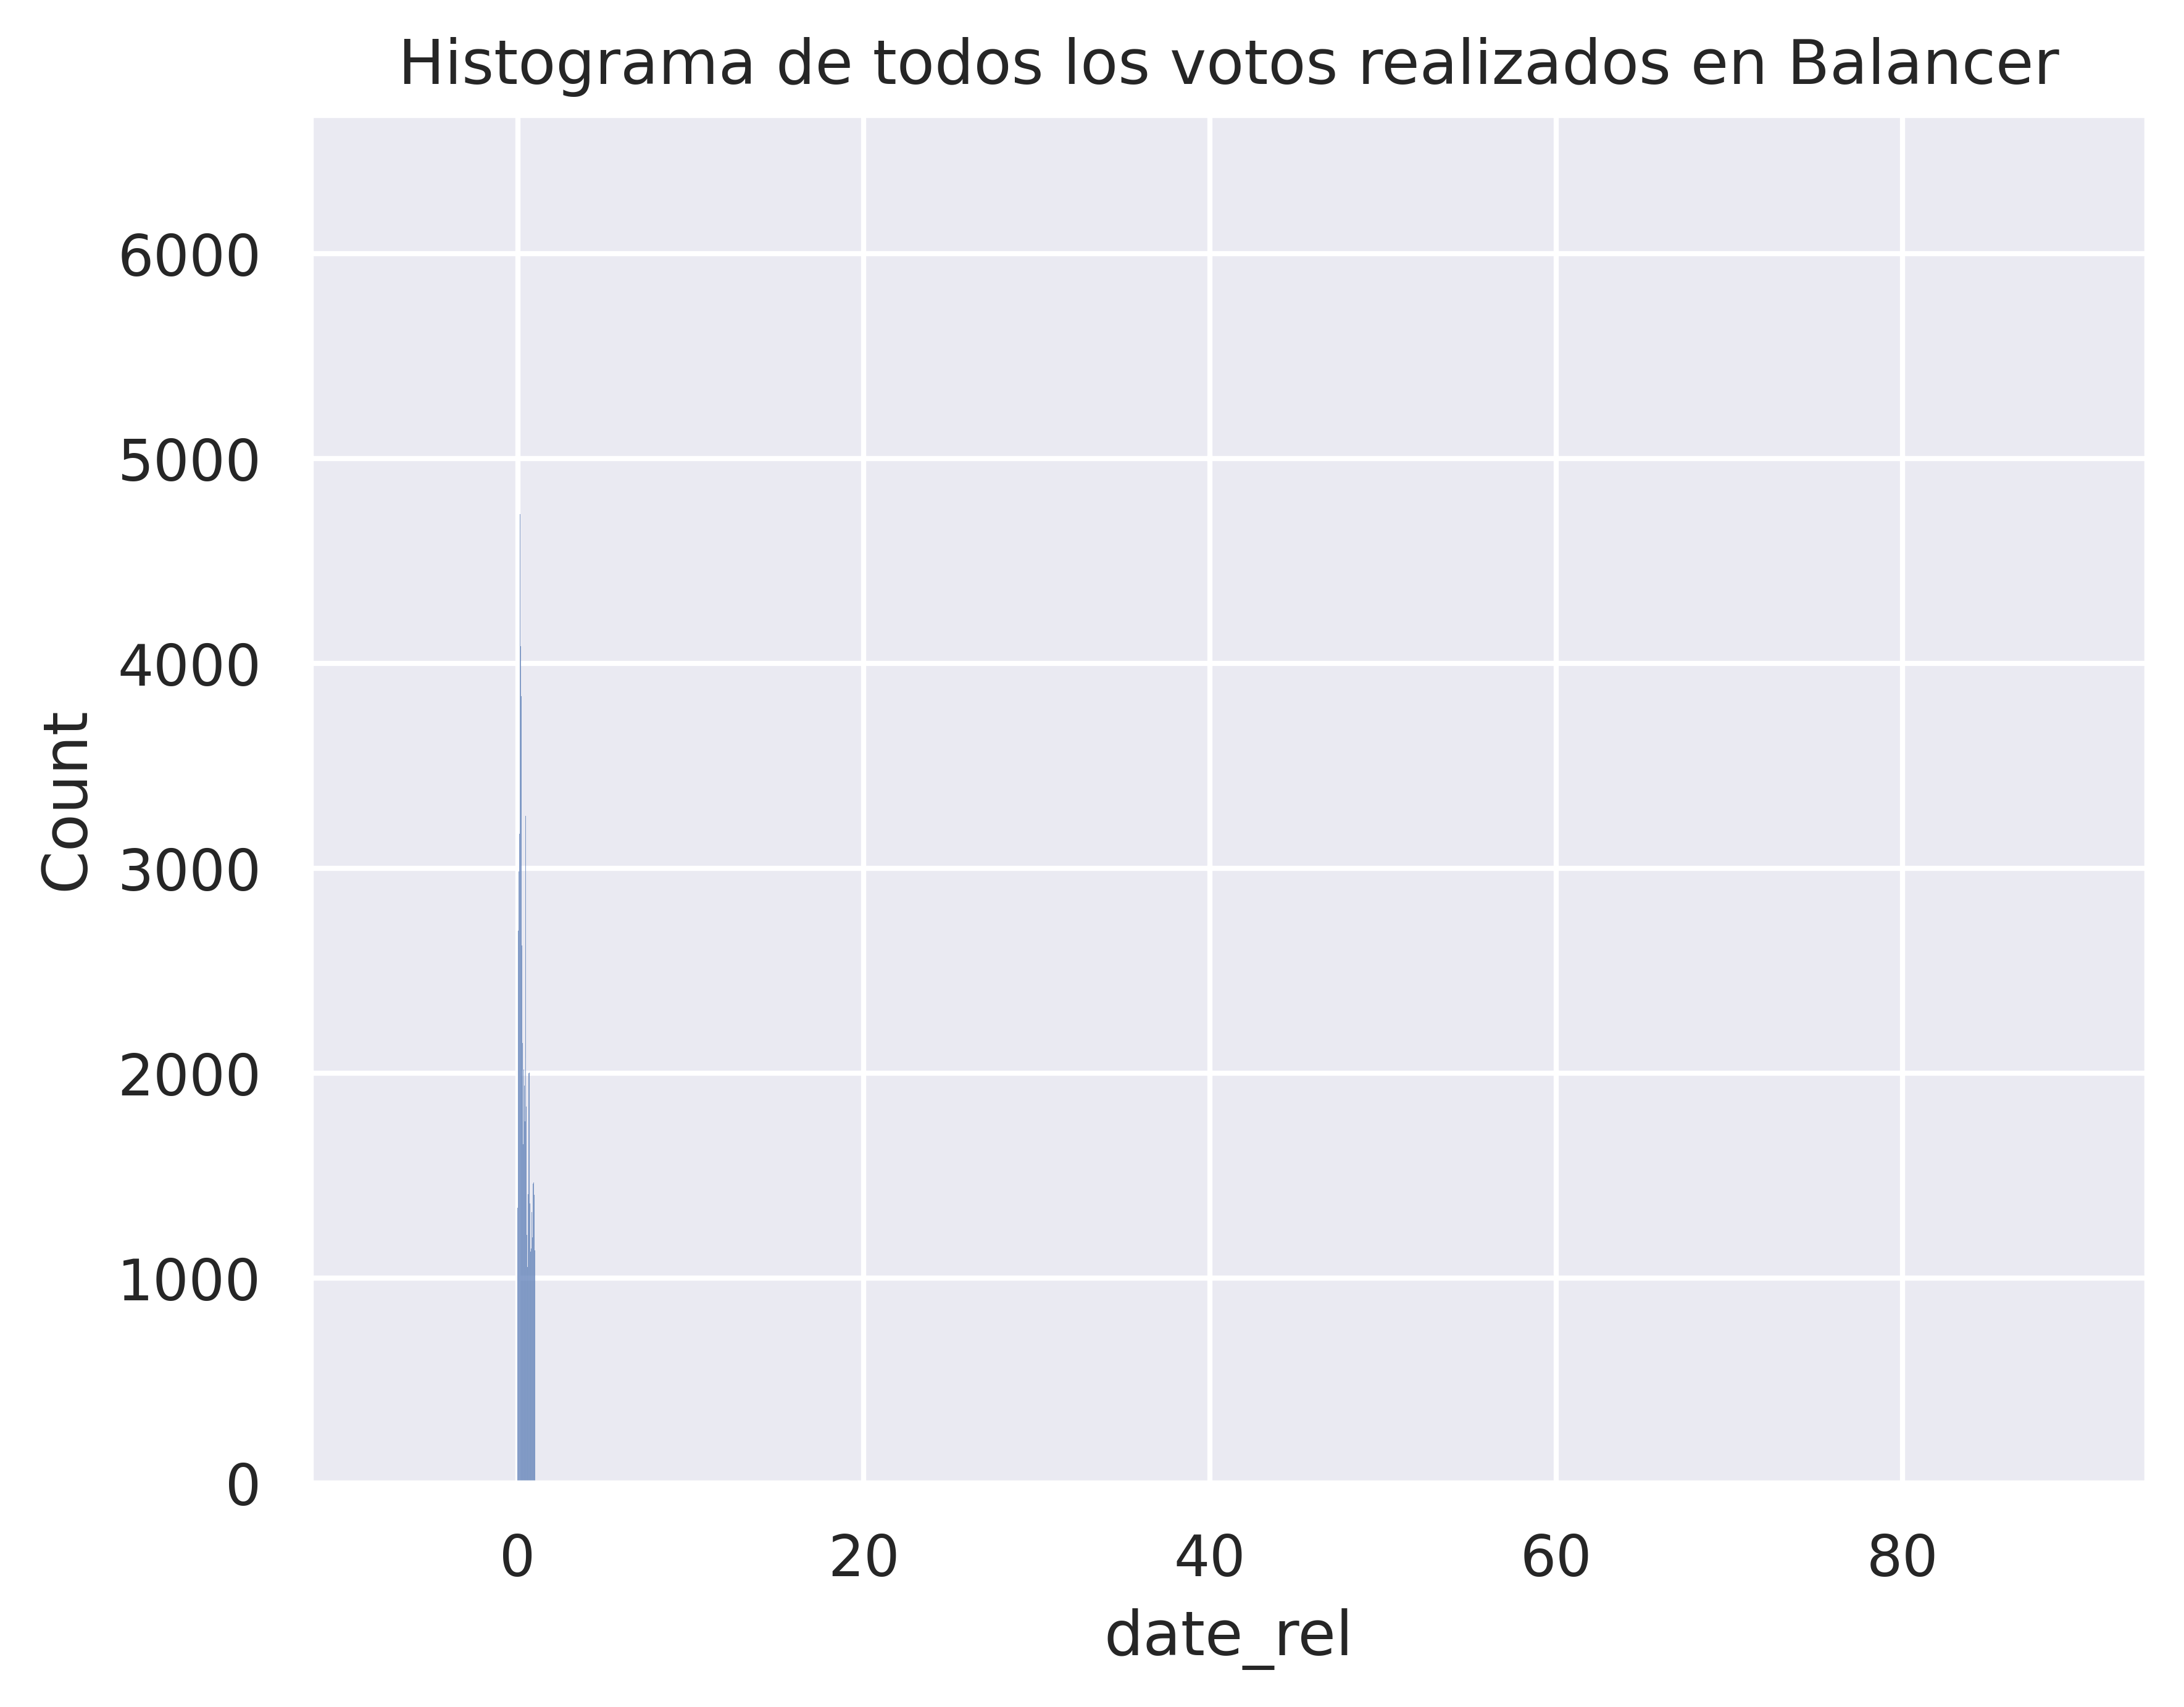

In [22]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [23]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

date_rel
count  111987.000000
mean        0.387196
std         0.415828
min        -7.157384
10%         0.065951
25%         0.143489
50%         0.312809
75%         0.624423
78%         0.659540
80%         0.682535
max        89.327894

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [24]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

platform      name                              proposal  \
25700  snapshot  Balancer  e41b9c54-4da0-554e-ad10-8a2397d4c2b2   
70894  snapshot  Balancer  f3a84703-d173-500e-83e5-d5314a5946ef   
70893  snapshot  Balancer  f3a84703-d173-500e-83e5-d5314a5946ef   
70892  snapshot  Balancer  f3a84703-d173-500e-83e5-d5314a5946ef   
25699  snapshot  Balancer  e41b9c54-4da0-554e-ad10-8a2397d4c2b2   
...         ...       ...                                   ...   
32101  snapshot  Balancer  4db5212d-7350-5ffd-b666-e43118aa20c0   
98609  snapshot  Balancer  44450f97-8c69-529b-b201-e7c5322ee709   
10010  snapshot  Balancer  3c092794-ba86-54f3-a760-ceb90c1e4c11   
80205  snapshot  Balancer  9fe9a5b6-9833-5801-8fcb-fa5eaa560791   
33061  snapshot  Balancer  7aa25e7a-d88f-551f-bd93-0f8093effe29   

                     date               start                 end  date_rel  \
25700 2020-07-18 16:12:04 2020-07-18 16:00:00 2020-07-19 16:00:00  0.008380   
70894 2020-07-18 16:12:18 2020-07-18 16:00:00 2020-07-19 16:00:00  0.008542   
70893 2020-07-18 16:12:22 2020-07-18 16:00:00 2020-07-19 16:00:00  0.008588   
70892 2020-07-18 16:12:39 2020-07-18 16:00:00 2020-07-19 16:00:00  0.008785   
25699 2020-07-18 16:13:31 2020-07-18 16:00:00 2020-07-19 16:00:00  0.009387   
...                   ...                 ...                 ...       ...   
32101 2023-07-17 16:45:33 2023-07-13 18:00:00 2023-07-17 18:00:00  0.987075   
98609 2023-07-17 17:55:48 2023-07-13 18:00:00 2023-07-17 18:00:00  0.999271   
10010 2023-07-17 17:56:20 2023-07-13 18:00:00 2023-07-17 18:00:00  0.999363   
80205 2023-07-17 17:56:48 2023-07-13 18:00:00 2023-07-17 18:00:00  0.999444   
33061 2023-07-17 17:57:23 2023-07-13 18:00:00 2023-07-17 18:00:00  0.999546   

           freq   cumfreq  
25700  0.013889  0.013889  
70894  0.010309  0.010309  
70893  0.010309  0.020619  
70892  0.010309  0.030928  
25699  0.013889  0.027778  
...         ...       ...  
32101  0.021739  1.000000  
98609  0.012048  1.000000  
10010  0.012987  1.000000  
80205  0.013889  1.000000  
33061  0.018182  1.000000  

[111987 rows x 9 columns]

In [25]:
_dfv2.groupby('proposal').size().sort_values()

proposal
5b5bb261-fb2e-5854-b693-db6c54266f67       8
97d5d8b5-4c67-5776-abea-d36d2e739d3f       9
7dae54f7-bfd3-5416-911a-d5b5eb869abf      10
30be4221-3dc2-5128-8d43-44804b2f42e1      14
3e97d057-66bf-50b7-b453-11fc1ea4e62a      15
                                        ... 
213cfd2d-a68d-5a4c-882c-5374e750bcb1    1663
0c1453e0-329d-5421-87ab-4cd936fff7f6    1682
8fbe4aca-e048-5d32-868a-152333169bce    1812
e948d41c-b8dd-538d-9b5d-0d5d32ac7460    1860
993bd589-e5cb-5889-959e-6cfe65a6afeb    2102
Length: 509, dtype: int64


### KDE plot de las más votadas

Text(0.5, 1.0, 'kde plot de las 15 propuestas más grandes en Balancer')

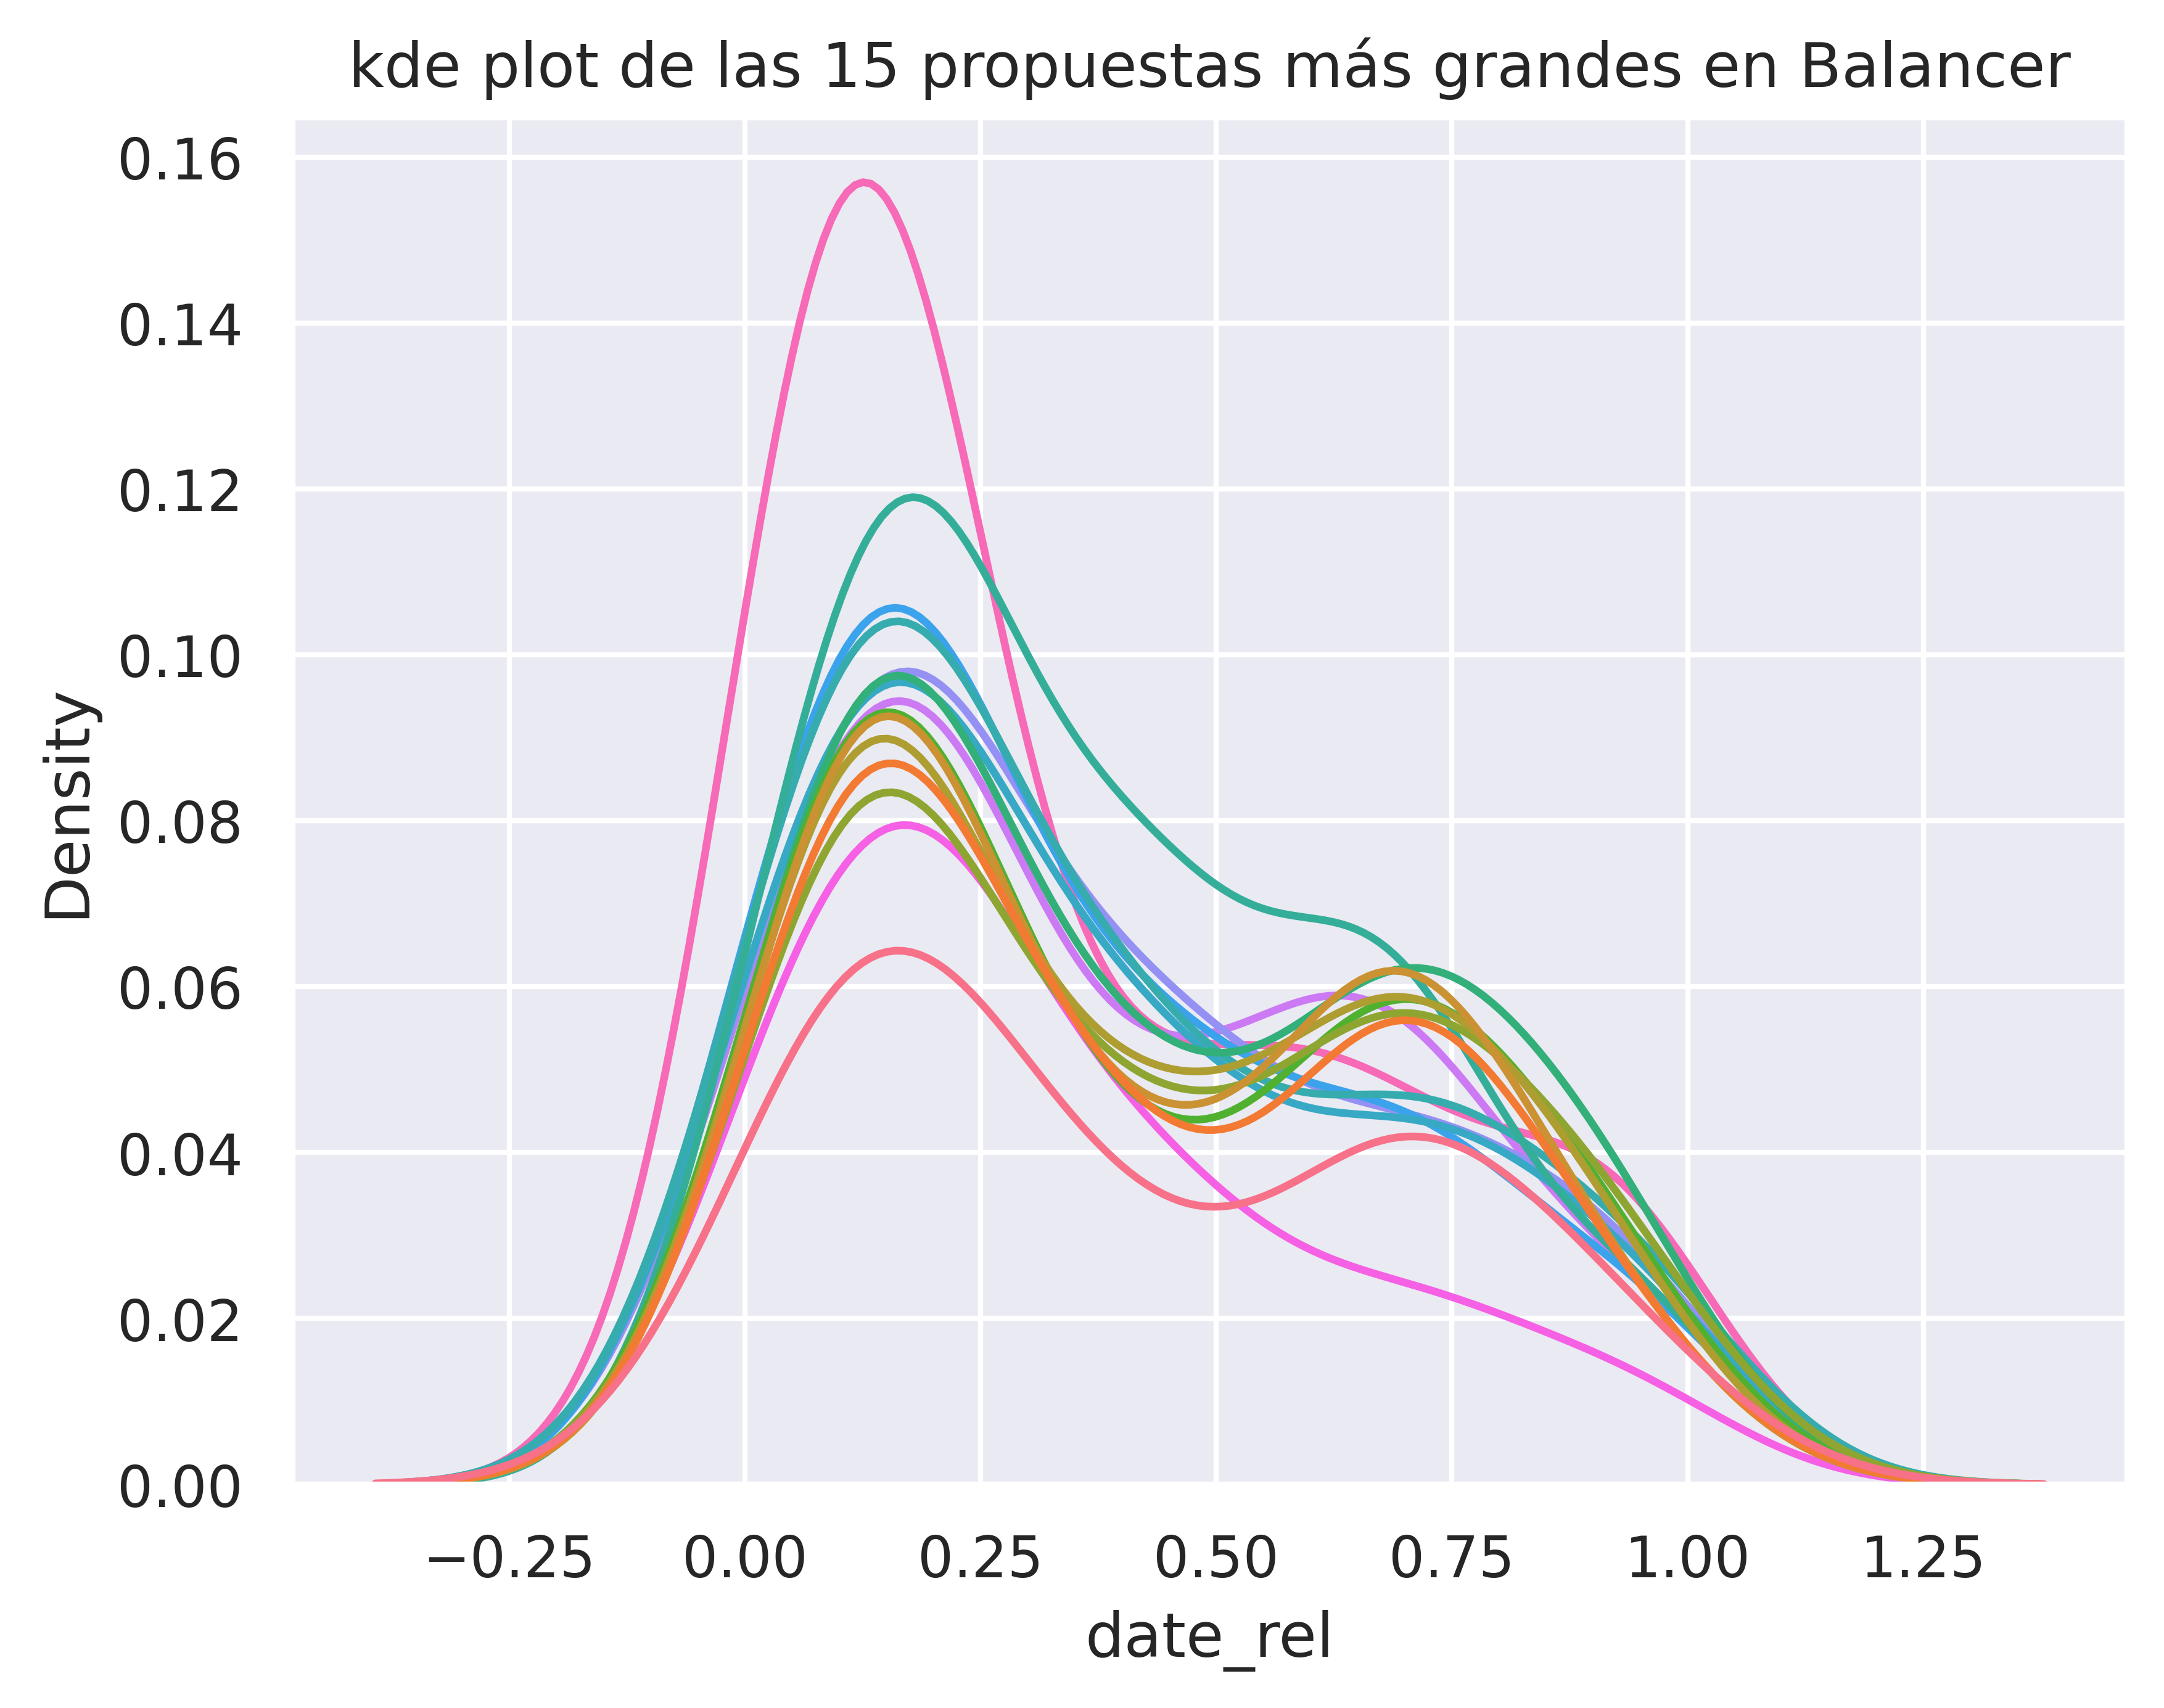

In [26]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.